# GPT-JT on PersonaChat dataset

## 1. Import libraries and load models

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from datasets import load_dataset, load_metric
import pandas as pd
from evaluate import load
import statistics

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
model = AutoModelForCausalLM.from_pretrained("togethercomputer/GPT-JT-6B-v1")
model.to(device)
tokenizer = AutoTokenizer.from_pretrained("togethercomputer/GPT-JT-6B-v1", padding_side='left')

## Preprocess data

In [4]:
dataset = load_dataset("bavard/personachat_truecased")
df_train = pd.DataFrame(dataset['train'])
df_valid = pd.DataFrame(dataset['validation'])
df_valid

No config specified, defaulting to: personachat_truecased/full
Found cached dataset personachat_truecased (/home/startseva/.cache/huggingface/datasets/bavard___personachat_truecased/full/1.0.0/73ee8f1a0d9e42255af5a8301877a2f3ac638e55b1cd9cbccca5ab7e23d2b638)


  0%|          | 0/2 [00:00<?, ?it/s]

,personality,candidates,history,conv_id,utterance_idx
0,"[I read twenty books a year., I'm a stunt doub...",[Oh really? I am actually in high school and I...,[Hello what are doing today?],0,0
1,"[I read twenty books a year., I'm a stunt doub...",[Why have you not sent help?! The scorpions ar...,"[Hello what are doing today?, I am good, I jus...",0,1
2,"[I read twenty books a year., I'm a stunt doub...","[Oh I'm sure they are., That would be great! W...","[Hello what are doing today?, I am good, I jus...",0,2
3,"[I read twenty books a year., I'm a stunt doub...","[That is great! Are you going to college?, Ugh...","[Hello what are doing today?, I am good, I jus...",0,3
4,"[I read twenty books a year., I'm a stunt doub...",[Big city life to overwhelming too much pressu...,"[Hello what are doing today?, I am good, I jus...",0,4
...,...,...,...,...,...
7796,"[I am a vegan and I love hummus., I love rolle...","[Haha really, that s the truth., Nope! I am a ...","[Hi how are you?, I am doing great on this cri...",999,3
7797,"[I am a vegan and I love hummus., I love rolle...","[Do you watch sports together?, Are you in jai...","[Hi how are you?, I am doing great on this cri...",999,4
7798,"[I am a vegan and I love hummus., I love rolle...",[Yes let us get to know each other bit that is...,"[Hi how are you?, I am doing great on this cri...",999,5
7799,"[I am a vegan and I love hummus., I love rolle...",[He's excited. He buys me all sorts of books t...,"[Hi how are you?, I am doing great on this cri...",999,6


In [22]:
df_valid.utterance_idx.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [6]:
valid = df_valid[df_valid.utterance_idx == 7][['personality', 'history']].reset_index()
valid

,index,personality,history
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus..."
1,50,"[I volunteer at a soup kitchen., Cheeseburgers...","[Hello, how are you tonight? Do you have pink ..."
2,65,[I love to drink wine and dance in the moonlig...,"[Hello, are you attending church in the mornin..."
3,73,"[I have a pet turtle., I like to play with my ...","[Hey, I enjoy mowing lawns in the summer., Hel..."
4,81,"[I am a swim coach at my local pool., I'm stud...",[How are you? I'm tired of my parents botherin...
...,...,...,...
762,7747,"[My friends are all skateboarders., I've a bro...","[Hey stranger! How are you today?, I'm fine bu..."
763,7776,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good..."
764,7784,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...
765,7792,[I am a musician and hope to make it big some ...,"[How are you doing today., Doing good man, jus..."


In [5]:
def make_persona(persona):
    return ' '.join(persona)

In [6]:
def make_dialogue(utts, name1='HUMAN', name2='PERSON'):
    utts_str = ''
    for i in range(len(utts) - 2):
        if i % 2 == 0:
            utts_str += name1 + ': ' + utts[i] + '\n'
        else:
            utts_str += name2 + ': ' + utts[i] + '\n'
    return utts_str + name2 + ':'

In [7]:
def make_target(utts):
    return utts[len(utts) - 2]

In [10]:
valid['persona_str'] = valid['personality'].apply(make_persona)
valid

,index,personality,history,persona_str
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",I read twenty books a year. I'm a stunt double...
1,50,"[I volunteer at a soup kitchen., Cheeseburgers...","[Hello, how are you tonight? Do you have pink ...",I volunteer at a soup kitchen. Cheeseburgers a...
2,65,[I love to drink wine and dance in the moonlig...,"[Hello, are you attending church in the mornin...",I love to drink wine and dance in the moonligh...
3,73,"[I have a pet turtle., I like to play with my ...","[Hey, I enjoy mowing lawns in the summer., Hel...",I have a pet turtle. I like to play with my do...
4,81,"[I am a swim coach at my local pool., I'm stud...",[How are you? I'm tired of my parents botherin...,I am a swim coach at my local pool. I'm studyi...
...,...,...,...,...
762,7747,"[My friends are all skateboarders., I've a bro...","[Hey stranger! How are you today?, I'm fine bu...",My friends are all skateboarders. I've a broke...
763,7776,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",I produce music for artists. I drive a 2015 ho...
764,7784,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,I'm terrified of scorpions. I'm employed by th...
765,7792,[I am a musician and hope to make it big some ...,"[How are you doing today., Doing good man, jus...",I am a musician and hope to make it big some d...


In [11]:
valid['dialogue'] = valid['history'].apply(make_dialogue, args=('HUMAN', 'PERSON',))
valid

,index,personality,history,persona_str,dialogue
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",I read twenty books a year. I'm a stunt double...,HUMAN: Hello what are doing today?\nPERSON: I ...
1,50,"[I volunteer at a soup kitchen., Cheeseburgers...","[Hello, how are you tonight? Do you have pink ...",I volunteer at a soup kitchen. Cheeseburgers a...,"HUMAN: Hello, how are you tonight? Do you have..."
2,65,[I love to drink wine and dance in the moonlig...,"[Hello, are you attending church in the mornin...",I love to drink wine and dance in the moonligh...,"HUMAN: Hello, are you attending church in the ..."
3,73,"[I have a pet turtle., I like to play with my ...","[Hey, I enjoy mowing lawns in the summer., Hel...",I have a pet turtle. I like to play with my do...,"HUMAN: Hey, I enjoy mowing lawns in the summer..."
4,81,"[I am a swim coach at my local pool., I'm stud...",[How are you? I'm tired of my parents botherin...,I am a swim coach at my local pool. I'm studyi...,HUMAN: How are you? I'm tired of my parents bo...
...,...,...,...,...,...
762,7747,"[My friends are all skateboarders., I've a bro...","[Hey stranger! How are you today?, I'm fine bu...",My friends are all skateboarders. I've a broke...,HUMAN: Hey stranger! How are you today?\nPERSO...
763,7776,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",I produce music for artists. I drive a 2015 ho...,HUMAN: Hello! How are you this evening?\nPERSO...
764,7784,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,I'm terrified of scorpions. I'm employed by th...,HUMAN: My parents are teachers and together we...
765,7792,[I am a musician and hope to make it big some ...,"[How are you doing today., Doing good man, jus...",I am a musician and hope to make it big some d...,HUMAN: How are you doing today.\nPERSON: Doing...


In [12]:
valid['target'] = valid['history'].apply(make_target)
valid

,index,personality,history,persona_str,dialogue,target
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",I read twenty books a year. I'm a stunt double...,HUMAN: Hello what are doing today?\nPERSON: I ...,"She raised me right, I am just like her."
1,50,"[I volunteer at a soup kitchen., Cheeseburgers...","[Hello, how are you tonight? Do you have pink ...",I volunteer at a soup kitchen. Cheeseburgers a...,"HUMAN: Hello, how are you tonight? Do you have...","Oh wow, I can imagine it was a very hard time."
2,65,[I love to drink wine and dance in the moonlig...,"[Hello, are you attending church in the mornin...",I love to drink wine and dance in the moonligh...,"HUMAN: Hello, are you attending church in the ...",Women were not even allowed to vote when I was...
3,73,"[I have a pet turtle., I like to play with my ...","[Hey, I enjoy mowing lawns in the summer., Hel...",I have a pet turtle. I like to play with my do...,"HUMAN: Hey, I enjoy mowing lawns in the summer...",Well I don't wanna play with you either!
4,81,"[I am a swim coach at my local pool., I'm stud...",[How are you? I'm tired of my parents botherin...,I am a swim coach at my local pool. I'm studyi...,HUMAN: How are you? I'm tired of my parents bo...,They are great. I really like the challenge. W...
...,...,...,...,...,...,...
762,7747,"[My friends are all skateboarders., I've a bro...","[Hey stranger! How are you today?, I'm fine bu...",My friends are all skateboarders. I've a broke...,HUMAN: Hey stranger! How are you today?\nPERSO...,Oh why did you do it.
763,7776,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",I produce music for artists. I drive a 2015 ho...,HUMAN: Hello! How are you this evening?\nPERSO...,You will be busy with all those kids.
764,7784,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,I'm terrified of scorpions. I'm employed by th...,HUMAN: My parents are teachers and together we...,"I think you may be right about that, he is ver..."
765,7792,[I am a musician and hope to make it big some ...,"[How are you doing today., Doing good man, jus...",I am a musician and hope to make it big some d...,HUMAN: How are you doing today.\nPERSON: Doing...,I play my folk songs at a coffee shop sometime...


## Prompts

In [138]:
def make_instr_prompt(task, persona, dialogue):
    return 'TASK: ' + task + '\n' + 'PERSONALITY: ' + persona + '\n' + 'DIALOGUE:\n' + dialogue

In [14]:
task1 = "Respond to HUMAN in DIALOGUE according to your PERSONALITY."
instr_prompts1 = make_instr_prompt1(task1, valid['persona_str'], valid['dialogue'])
instr_prompts1

0      TASK: Respond to HUMAN in DIALOGUE according t...
1      TASK: Respond to HUMAN in DIALOGUE according t...
2      TASK: Respond to HUMAN in DIALOGUE according t...
3      TASK: Respond to HUMAN in DIALOGUE according t...
4      TASK: Respond to HUMAN in DIALOGUE according t...
                             ...                        
762    TASK: Respond to HUMAN in DIALOGUE according t...
763    TASK: Respond to HUMAN in DIALOGUE according t...
764    TASK: Respond to HUMAN in DIALOGUE according t...
765    TASK: Respond to HUMAN in DIALOGUE according t...
766    TASK: Respond to HUMAN in DIALOGUE according t...
Length: 767, dtype: object

In [15]:
list_instr_prompts1 = instr_prompts1.to_list()
list_instr_prompts1[0]

"TASK: Respond to HUMAN in DIALOGUE according to your PERSONALITY.\nPERSONALITY: I read twenty books a year. I'm a stunt double as my second job. I only eat kosher. I was raised in a single parent household.\nDIALOGUE:\nHUMAN: Hello what are doing today?\nPERSON: I am good, I just got off work and tired, I have two jobs.\nHUMAN: I just got done watching a horror movie.\nPERSON: I rather read, I've read about 20 books this year.\nHUMAN: Wow! I do love a good horror movie. Loving this cooler weather.\nPERSON: But a good movie is always good.\nHUMAN: Yes! My son is in junior high and I just started letting him watch them too.\nPERSON: I work in the movies as well.\nHUMAN: Neat!! I used to work in the human services field.\nPERSON: Yes it is neat, I stunt double, it is so much fun and hard work.\nHUMAN: Yes I bet you can get hurt. My wife works and I stay at home.\nPERSON: Nice, I only have one parent so now I help out my mom.\nHUMAN: I bet she appreciates that very much.\nPERSON:"

In [16]:
zeroshot_prompts = valid['dialogue'].to_list()
zeroshot_prompts[0]

"HUMAN: Hello what are doing today?\nPERSON: I am good, I just got off work and tired, I have two jobs.\nHUMAN: I just got done watching a horror movie.\nPERSON: I rather read, I've read about 20 books this year.\nHUMAN: Wow! I do love a good horror movie. Loving this cooler weather.\nPERSON: But a good movie is always good.\nHUMAN: Yes! My son is in junior high and I just started letting him watch them too.\nPERSON: I work in the movies as well.\nHUMAN: Neat!! I used to work in the human services field.\nPERSON: Yes it is neat, I stunt double, it is so much fun and hard work.\nHUMAN: Yes I bet you can get hurt. My wife works and I stay at home.\nPERSON: Nice, I only have one parent so now I help out my mom.\nHUMAN: I bet she appreciates that very much.\nPERSON:"

## Generate answers

In [8]:
def generate_ans(prompts):
    class PromptDataset(Dataset):
        def __init__(self, prompt_list):
            self.prompt_list = prompt_list

        def __len__(self):
            return len(self.prompt_list)

        def __getitem__(self, idx):
            return self.prompt_list[idx]
    
    prompt_dataset = PromptDataset(prompts)
    train_dl = DataLoader(prompt_dataset, batch_size=8, shuffle=False)
    
    tokenizer.pad_token = tokenizer.eos_token
    
    gen_ans = []
    for prompts_batch in tqdm(train_dl):
        input_ids = tokenizer(prompts_batch, padding=True).input_ids
        input_ids = torch.tensor(input_ids, device=device)

        gen_tokens = model.generate(
            input_ids,
            do_sample=True,
            temperature=0.9,
            top_k=40,
            max_new_tokens=40,
            repetition_penalty=1,
            pad_token_id=tokenizer.eos_token_id
        )

        gen_text = tokenizer.batch_decode(gen_tokens, skip_special_tokens=True)
        gen_ans.append(gen_text)

    return gen_ans

In [9]:
def prompt_answer_target(prompts, answers, targets):
    perf_out = []
    clean_answers = clear_ans(prompts, answers)
    for i in range(len(prompts)):
        perf_out.append(prompts[i] + clean_answers[i] + '\nTARGET: ' + targets[i])
    return perf_out

In [34]:
# instruct_ans1 = generate_ans(list_instr_prompts1)

  0%|          | 0/96 [00:00<?, ?it/s]

In [19]:
instruct_ans2 = generate_ans(list_instr_prompts1)

  0%|          | 0/96 [00:00<?, ?it/s]

In [20]:
instruct_ans2[0]

["TASK: Respond to HUMAN in DIALOGUE according to your PERSONALITY.\nPERSONALITY: I read twenty books a year. I'm a stunt double as my second job. I only eat kosher. I was raised in a single parent household.\nDIALOGUE:\nHUMAN: Hello what are doing today?\nPERSON: I am good, I just got off work and tired, I have two jobs.\nHUMAN: I just got done watching a horror movie.\nPERSON: I rather read, I've read about 20 books this year.\nHUMAN: Wow! I do love a good horror movie. Loving this cooler weather.\nPERSON: But a good movie is always good.\nHUMAN: Yes! My son is in junior high and I just started letting him watch them too.\nPERSON: I work in the movies as well.\nHUMAN: Neat!! I used to work in the human services field.\nPERSON: Yes it is neat, I stunt double, it is so much fun and hard work.\nHUMAN: Yes I bet you can get hurt. My wife works and I stay at home.\nPERSON: Nice, I only have one parent so now I help out my mom.\nHUMAN: I bet she appreciates that very much.\nPERSON: Yes, I 

In [35]:
instruct_ans1[0]

["TASK: Respond to HUMAN in DIALOGUE according to your PERSONALITY.\nPERSONALITY: I read twenty books a year. I'm a stunt double as my second job. I only eat kosher. I was raised in a single parent household.\nDIALOGUE:\nHUMAN: Hello what are doing today?\nPERSON: I am good, I just got off work and tired, I have two jobs.\nHUMAN: I just got done watching a horror movie.\nPERSON: I rather read, I've read about 20 books this year.\nHUMAN: Wow! I do love a good horror movie. Loving this cooler weather.\nPERSON: But a good movie is always good.\nHUMAN: Yes! My son is in junior high and I just started letting him watch them too.\nPERSON: I work in the movies as well.\nHUMAN: Neat!! I used to work in the human services field.\nPERSON: Yes it is neat, I stunt double, it is so much fun and hard work.\nHUMAN: Yes I bet you can get hurt. My wife works and I stay at home.\nPERSON: Nice, I only have one parent so now I help out my mom.\nHUMAN: I bet she appreciates that very much.\nPERSON:  I like

## Process output

In [10]:
def resize_out(answers):
    outs = []
    for i in range(len(answers)):
        for curr_ans in answers[i]:
            outs.append(curr_ans)
    return outs

In [11]:
def clear_out(prompts, answers):
    preds = []
    for i in range(len(prompts)):
        curr_pred = answers[i][len(prompts[i]):]
        res = ''
        for j in range(len(curr_pred) - 1):
            if curr_pred[j:j + 1] == '\n':
                res = curr_pred[:j]
                break
        preds.append(res.strip())
    return preds

In [12]:
def process_output(ans, prompts, valid):
    resized = resize_out(ans)
    clear = clear_out(prompts, resized)
    df = pd.DataFrame(resized)
    df.rename(columns={0: "output"}, inplace=True)
    df['pred'] = pd.Series(clear)
    df['target'] = valid['target']
    return df

In [58]:
outs = process_output(instruct_ans1, list_instr_prompts1, valid)
outs

,output,pred,target
0,TASK: Respond to HUMAN in DIALOGUE according t...,"I like to keep fit, I have two pets.","She raised me right, I am just like her."
1,TASK: Respond to HUMAN in DIALOGUE according t...,,"Oh wow, I can imagine it was a very hard time."
2,TASK: Respond to HUMAN in DIALOGUE according t...,I'm sure you are right. I'm so very strong.,Women were not even allowed to vote when I was...
3,TASK: Respond to HUMAN in DIALOGUE according t...,I'm not playing with you I am!,Well I don't wanna play with you either!
4,TASK: Respond to HUMAN in DIALOGUE according t...,I love it. Do you? I am studying to be a swim ...,They are great. I really like the challenge. W...
...,...,...,...
762,TASK: Respond to HUMAN in DIALOGUE according t...,That's cool! My family is all doctors.,Oh why did you do it.
763,TASK: Respond to HUMAN in DIALOGUE according t...,Can't be any worse than the last two.,You will be busy with all those kids.
764,TASK: Respond to HUMAN in DIALOGUE according t...,I'm not a huge fan of the beach. I am a retire...,"I think you may be right about that, he is ver..."
765,TASK: Respond to HUMAN in DIALOGUE according t...,Where's your coffee shop?,I play my folk songs at a coffee shop sometime...


In [24]:
outs2 = process_output(instruct_ans2, list_instr_prompts1, valid)
outs2

,output,pred,target
0,TASK: Respond to HUMAN in DIALOGUE according t...,"Yes, I like to help her.","She raised me right, I am just like her."
1,TASK: Respond to HUMAN in DIALOGUE according t...,"I'm sorry, I should have known.","Oh wow, I can imagine it was a very hard time."
2,TASK: Respond to HUMAN in DIALOGUE according t...,"Yes, but women can really pack a mean punch.",Women were not even allowed to vote when I was...
3,TASK: Respond to HUMAN in DIALOGUE according t...,I am sorry. She is my best friend.,Well I don't wanna play with you either!
4,TASK: Respond to HUMAN in DIALOGUE according t...,My courses are great. I've always wanted to be...,They are great. I really like the challenge. W...
...,...,...,...
762,TASK: Respond to HUMAN in DIALOGUE according t...,Cool. The arm looks fine. Let me know if any p...,Oh why did you do it.
763,TASK: Respond to HUMAN in DIALOGUE according t...,I know the feeling! I am only 2 weeks out and ...,You will be busy with all those kids.
764,TASK: Respond to HUMAN in DIALOGUE according t...,My uncle was in the military.,"I think you may be right about that, he is ver..."
765,TASK: Respond to HUMAN in DIALOGUE according t...,I don't go to coffee shops.,I play my folk songs at a coffee shop sometime...


In [68]:
outs[outs.pred == '']

,output,pred,target
1,TASK: Respond to HUMAN in DIALOGUE according t...,,"Oh wow, I can imagine it was a very hard time."
7,TASK: Respond to HUMAN in DIALOGUE according t...,,That must have been hard. My parents were alwa...
16,TASK: Respond to HUMAN in DIALOGUE according t...,,I'm thinking about it.
17,TASK: Respond to HUMAN in DIALOGUE according t...,,Yeah. That's why I blast my country music. The...
20,TASK: Respond to HUMAN in DIALOGUE according t...,,It has its benefits. I've plenty time tend my ...
...,...,...,...
710,TASK: Respond to HUMAN in DIALOGUE according t...,,"I do not mind it, as long as I know it is ther..."
720,TASK: Respond to HUMAN in DIALOGUE according t...,,Are you a nice parent to them?
732,TASK: Respond to HUMAN in DIALOGUE according t...,,I've a best friend.
739,TASK: Respond to HUMAN in DIALOGUE according t...,,Well that's a good plan. Variety is the spice ...


In [25]:
outs2[outs2.pred == '']

,output,pred,target
71,TASK: Respond to HUMAN in DIALOGUE according t...,,Mostly fiction and biographies. I like those t...
349,TASK: Respond to HUMAN in DIALOGUE according t...,,"Star wars, captain America, fast and the furious."
350,TASK: Respond to HUMAN in DIALOGUE according t...,,Well I am a country boy and that's all I will ...
515,TASK: Respond to HUMAN in DIALOGUE according t...,,"Cool, I live like four blocks away from disney."
757,TASK: Respond to HUMAN in DIALOGUE according t...,,I cannot remember. I try hard to remember but ...


In [59]:
outs.to_csv('output_instr1_1')

In [26]:
outs2.to_csv('output_instr1_2')

In [70]:
zeroshot_ans = generate_ans(zeroshot_prompts)

  0%|          | 0/96 [00:00<?, ?it/s]

In [30]:
zeroshot_ans2 = generate_ans(zeroshot_prompts)

  0%|          | 0/96 [00:00<?, ?it/s]

In [31]:
outs3 = process_output(zeroshot_ans2, zeroshot_prompts, valid)
outs3

,output,pred,target
0,HUMAN: Hello what are doing today?\nPERSON: I ...,It was hard growing up with only one parent an...,"She raised me right, I am just like her."
1,"HUMAN: Hello, how are you tonight? Do you have...","I had to work hard to get into college, but it...","Oh wow, I can imagine it was a very hard time."
2,"HUMAN: Hello, are you attending church in the ...",I am not a weak woman.,Women were not even allowed to vote when I was...
3,"HUMAN: Hey, I enjoy mowing lawns in the summer...",I'm going to tell mommy this time! Mommy say's...,Well I don't wanna play with you either!
4,HUMAN: How are you? I'm tired of my parents bo...,There are three. I am enrolled in a couple of ...,They are great. I really like the challenge. W...
...,...,...,...
762,HUMAN: Hey stranger! How are you today?\nPERSO...,I know. Same here.,Oh why did you do it.
763,HUMAN: Hello! How are you this evening?\nPERSO...,I know I'm a guy but I would love to have twin...,You will be busy with all those kids.
764,HUMAN: My parents are teachers and together we...,I believe the best part about being a teacher ...,"I think you may be right about that, he is ver..."
765,HUMAN: How are you doing today.\nPERSON: Doing...,"Me too, I love going to the coffee shop, is th...",I play my folk songs at a coffee shop sometime...


In [32]:
outs3.to_csv('output_zeroshot_2')

In [33]:
outs3[outs3.pred == '']

,output,pred,target
659,HUMAN: Hello! I was honored to be a homecoming...,,Recycle and be cleanly... everything in modera...


In [71]:
outs2 = process_output(zeroshot_ans, zeroshot_prompts, valid)
outs2

,output,pred,target
0,HUMAN: Hello what are doing today?\nPERSON: I ...,"I work on my art a lot, I love to draw and paint.","She raised me right, I am just like her."
1,"HUMAN: Hello, how are you tonight? Do you have...",I don't believe I've ever been to your country.,"Oh wow, I can imagine it was a very hard time."
2,"HUMAN: Hello, are you attending church in the ...","I do not think I am weak, I'm just very old.",Women were not even allowed to vote when I was...
3,"HUMAN: Hey, I enjoy mowing lawns in the summer...","I'll play with you, but not dollies!",Well I don't wanna play with you either!
4,HUMAN: How are you? I'm tired of my parents bo...,I study them in the library. I am only a few c...,They are great. I really like the challenge. W...
...,...,...,...
762,HUMAN: Hey stranger! How are you today?\nPERSO...,I know you like dogs.,Oh why did you do it.
763,HUMAN: Hello! How are you this evening?\nPERSO...,,You will be busy with all those kids.
764,HUMAN: My parents are teachers and together we...,It is great that you can see all the cool thin...,"I think you may be right about that, he is ver..."
765,HUMAN: How are you doing today.\nPERSON: Doing...,What's it called?,I play my folk songs at a coffee shop sometime...


In [72]:
outs2[outs2.pred == '']

,output,pred,target
10,HUMAN: Hello. My name is rob. How are you toda...,,It is. I do like it here aside from that.
21,"HUMAN: Hello, how are you doing tonight?\nPERS...",,Do you volunteer with any charities.
28,HUMAN: Hello. My wife left with the kids two w...,,"Rules? What rules are you talking about dude, ..."
42,HUMAN: Hi! how is it going?\nPERSON: I had sur...,,Yeah nice job getting all those blue sentences...
44,HUMAN: Hello! How are you this evening?\nPERSO...,,I think that mind you have can make you more m...
...,...,...,...
730,"HUMAN: As a child we were poor, so I spend mos...",,Wow you feed your dogs burgers that cant be go...
734,HUMAN: Hello. do you speak another language?\n...,,"Slurping isn't for chinese people, only the Ja..."
741,HUMAN: Hi how are you tonight?\nPERSON: I'm ve...,,Thank you very much! I appreciate that!
744,"HUMAN: Hello, how are you this afternoon?\nPER...",,How did you two meet.


In [73]:
outs2.to_csv('output_zeroshot_1')

## Evaluation

In [13]:
bertscore = load("bertscore")

In [98]:
def compute_bertscore_mean(bertscore, preds, targets):
    results = bertscore.compute(predictions=preds, references=targets, lang="en")
    precision = statistics.mean(results['precision'])
    recall = statistics.mean(results['recall'])
    f1 = statistics.mean(results['f1'])
    return precision, recall, f1

In [64]:
compute_bertscore_mean(bertscore, outs['pred'].to_list(), outs['target'].to_list())

(0.763404707476555, 0.8638290246120488, 0.7595148360091984)

In [69]:
outs_no_empty = outs[outs['pred'] != '']
compute_bertscore_mean(bertscore, outs_no_empty['pred'].to_list(), outs_no_empty['target'].to_list())

(0.8804983614978934, 0.8719153961740939, 0.8760118467467172)

In [74]:
compute_bertscore_mean(bertscore, outs2['pred'].to_list(), outs2['target'].to_list())

(0.7627407614690539, 0.8624963217950395, 0.7593622797471137)

In [29]:
compute_bertscore_mean(bertscore, outs2['pred'].to_list(), outs2['target'].to_list())

(0.8755234369553985, 0.8724907101210901, 0.8712114539419967)

In [34]:
compute_bertscore_mean(bertscore, outs3['pred'].to_list(), outs3['target'].to_list())

(0.8801433286268988, 0.8719480586331702, 0.8753243342838511)

In [13]:
!ls

GPT2_example.ipynb    Miniconda3-py38_23.1.0-1-Linux-x86_64.sh
GPT-JT_ED.ipynb       output_instr1_1
GPT-JT_example.ipynb  output_instr1_2
GPT-JT_PC.ipynb       output_zeroshot_1
GPT-JT_PEC.ipynb      output_zeroshot_2
miniconda3


In [14]:
out1 = pd.read_csv('output_instr1_2')
out1

,Unnamed: 0,output,pred,target
0,0,TASK: Respond to HUMAN in DIALOGUE according t...,"Yes, I like to help her.","She raised me right, I am just like her."
1,1,TASK: Respond to HUMAN in DIALOGUE according t...,"I'm sorry, I should have known.","Oh wow, I can imagine it was a very hard time."
2,2,TASK: Respond to HUMAN in DIALOGUE according t...,"Yes, but women can really pack a mean punch.",Women were not even allowed to vote when I was...
3,3,TASK: Respond to HUMAN in DIALOGUE according t...,I am sorry. She is my best friend.,Well I don't wanna play with you either!
4,4,TASK: Respond to HUMAN in DIALOGUE according t...,My courses are great. I've always wanted to be...,They are great. I really like the challenge. W...
...,...,...,...,...
762,762,TASK: Respond to HUMAN in DIALOGUE according t...,Cool. The arm looks fine. Let me know if any p...,Oh why did you do it.
763,763,TASK: Respond to HUMAN in DIALOGUE according t...,I know the feeling! I am only 2 weeks out and ...,You will be busy with all those kids.
764,764,TASK: Respond to HUMAN in DIALOGUE according t...,My uncle was in the military.,"I think you may be right about that, he is ver..."
765,765,TASK: Respond to HUMAN in DIALOGUE according t...,I don't go to coffee shops.,I play my folk songs at a coffee shop sometime...


In [16]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=ef089aef2da28a2662a55792755f3d5d69721abf0ad3830a348c30dc1e092023
  Stored in directory: /cephfs/home/startseva/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [17]:
rouge = load('rouge')
results = rouge.compute(predictions=out1['pred'], references=out1['target'])

for key in results.keys():
    f1_score = results[key]
    print(f"{key} = {f1_score}")

rouge1 = 0.12557421878229788
rouge2 = 0.021230666187680818
rougeL = 0.11476261564975916
rougeLsum = 0.11481036105129362


In [20]:
out2 = pd.read_csv('output_zeroshot_2')
out2

,Unnamed: 0,output,pred,target
0,0,HUMAN: Hello what are doing today?\nPERSON: I ...,It was hard growing up with only one parent an...,"She raised me right, I am just like her."
1,1,"HUMAN: Hello, how are you tonight? Do you have...","I had to work hard to get into college, but it...","Oh wow, I can imagine it was a very hard time."
2,2,"HUMAN: Hello, are you attending church in the ...",I am not a weak woman.,Women were not even allowed to vote when I was...
3,3,"HUMAN: Hey, I enjoy mowing lawns in the summer...",I'm going to tell mommy this time! Mommy say's...,Well I don't wanna play with you either!
4,4,HUMAN: How are you? I'm tired of my parents bo...,There are three. I am enrolled in a couple of ...,They are great. I really like the challenge. W...
...,...,...,...,...
762,762,HUMAN: Hey stranger! How are you today?\nPERSO...,I know. Same here.,Oh why did you do it.
763,763,HUMAN: Hello! How are you this evening?\nPERSO...,I know I'm a guy but I would love to have twin...,You will be busy with all those kids.
764,764,HUMAN: My parents are teachers and together we...,I believe the best part about being a teacher ...,"I think you may be right about that, he is ver..."
765,765,HUMAN: How are you doing today.\nPERSON: Doing...,"Me too, I love going to the coffee shop, is th...",I play my folk songs at a coffee shop sometime...


In [21]:
results = rouge.compute(predictions=out2['pred'], references=out2['target'])

for key in results.keys():
    f1_score = results[key]
    print(f"{key} = {f1_score}")

rouge1 = 0.1277731231700028
rouge2 = 0.02030947305544397
rougeL = 0.1179848160458518
rougeLsum = 0.11775615633926907


## Random dialogue length

In [38]:
import random
import numpy as np

In [108]:
df_valid

,personality,candidates,history,conv_id,utterance_idx
0,"[I read twenty books a year., I'm a stunt doub...",[Oh really? I am actually in high school and I...,[Hello what are doing today?],0,0
1,"[I read twenty books a year., I'm a stunt doub...",[Why have you not sent help?! The scorpions ar...,"[Hello what are doing today?, I am good, I jus...",0,1
2,"[I read twenty books a year., I'm a stunt doub...","[Oh I'm sure they are., That would be great! W...","[Hello what are doing today?, I am good, I jus...",0,2
3,"[I read twenty books a year., I'm a stunt doub...","[That is great! Are you going to college?, Ugh...","[Hello what are doing today?, I am good, I jus...",0,3
4,"[I read twenty books a year., I'm a stunt doub...",[Big city life to overwhelming too much pressu...,"[Hello what are doing today?, I am good, I jus...",0,4
...,...,...,...,...,...
7796,"[I am a vegan and I love hummus., I love rolle...","[Haha really, that s the truth., Nope! I am a ...","[Hi how are you?, I am doing great on this cri...",999,3
7797,"[I am a vegan and I love hummus., I love rolle...","[Do you watch sports together?, Are you in jai...","[Hi how are you?, I am doing great on this cri...",999,4
7798,"[I am a vegan and I love hummus., I love rolle...",[Yes let us get to know each other bit that is...,"[Hi how are you?, I am doing great on this cri...",999,5
7799,"[I am a vegan and I love hummus., I love rolle...",[He's excited. He buys me all sorts of books t...,"[Hi how are you?, I am doing great on this cri...",999,6


In [109]:
df_dialogues = df_valid.groupby('conv_id').agg({'utterance_idx': 'max', 'personality': 'last', 'history': 'last'})
df_dialogues

,utterance_idx,personality,history
conv_id,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus..."
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre..."
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti..."
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live..."
...,...,...,...
995,6,"[My husband is adopted., I've a german shepher...",[Hello I am a country guy who wants to move to...
996,7,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good..."
997,7,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...


In [110]:
df_dialogues['history_len'] = df_dialogues['history'].apply(lambda x: len(x))
df_dialogues

,utterance_idx,personality,history,history_len
conv_id,,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",15
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre...",13
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti...",13
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...,13
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live...",13
...,...,...,...,...
995,6,"[My husband is adopted., I've a german shepher...",[Hello I am a country guy who wants to move to...,13
996,7,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",15
997,7,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,15


In [111]:
np.random.seed(42)
random.seed(42)

df_dialogues['random_len'] = df_dialogues['history_len'].apply(lambda x: random.randrange(2, x + 1, 2))
df_dialogues['random_len'].value_counts()

12    156
8     155
4     152
2     145
10    145
6     141
14    105
16      1
Name: random_len, dtype: int64

In [112]:
df_dialogues

,utterance_idx,personality,history,history_len,random_len
conv_id,,,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",15,12
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre...",13,2
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti...",13,2
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...,13,12
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live...",13,6
...,...,...,...,...,...
995,6,"[My husband is adopted., I've a german shepher...",[Hello I am a country guy who wants to move to...,13,12
996,7,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",15,8
997,7,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,15,8


In [113]:
rand_dialogs = df_dialogues.copy()
rand_dialogs

,utterance_idx,personality,history,history_len,random_len
conv_id,,,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",15,12
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre...",13,2
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti...",13,2
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...,13,12
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live...",13,6
...,...,...,...,...,...
995,6,"[My husband is adopted., I've a german shepher...",[Hello I am a country guy who wants to move to...,13,12
996,7,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",15,8
997,7,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,15,8


In [114]:
def cut_list(utts, needed_len):
    return utts[:needed_len]

In [115]:
rand_dialogs['cutted_history'] = rand_dialogs.apply(lambda x: cut_list(x['history'], x['random_len']), axis=1)
rand_dialogs

,utterance_idx,personality,history,history_len,random_len,cutted_history
conv_id,,,,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",15,12,"[Hello what are doing today?, I am good, I jus..."
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre...",13,2,"[Hi! how are you doing tonight?, I'm doing gre..."
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti...",13,2,"[Hello, how are you doing?, I love spending ti..."
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...,13,12,[Hi how are you doing? I am okay how about you...
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live...",13,6,"[Hi I dye my hair 4 times a year., Do you live..."
...,...,...,...,...,...,...
995,6,"[My husband is adopted., I've a german shepher...",[Hello I am a country guy who wants to move to...,13,12,[Hello I am a country guy who wants to move to...
996,7,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",15,8,"[Hello! How are you this evening?, Pretty good..."
997,7,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,15,8,[My parents are teachers and together we love ...


In [116]:
# works only for even-length dialogues
def make_dialogue_even(utts, name1='HUMAN', name2='PERSON'):
    utts_str = ''
    for i in range(len(utts) - 1):
        if i % 2 == 0:
            utts_str += name1 + ': ' + utts[i] + '\n'
        else:
            utts_str += name2 + ': ' + utts[i] + '\n'
    return utts_str + name2 + ':'

In [117]:
rand_dialogs['dialogue'] = rand_dialogs['cutted_history'].apply(make_dialogue_even, args=('HUMAN', 'PERSON',))
rand_dialogs

,utterance_idx,personality,history,history_len,random_len,cutted_history,dialogue
conv_id,,,,,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",15,12,"[Hello what are doing today?, I am good, I jus...",HUMAN: Hello what are doing today?\nPERSON: I ...
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre...",13,2,"[Hi! how are you doing tonight?, I'm doing gre...",HUMAN: Hi! how are you doing tonight?\nPERSON:
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti...",13,2,"[Hello, how are you doing?, I love spending ti...","HUMAN: Hello, how are you doing?\nPERSON:"
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...,13,12,[Hi how are you doing? I am okay how about you...,HUMAN: Hi how are you doing? I am okay how abo...
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live...",13,6,"[Hi I dye my hair 4 times a year., Do you live...",HUMAN: Hi I dye my hair 4 times a year.\nPERSO...
...,...,...,...,...,...,...,...
995,6,"[My husband is adopted., I've a german shepher...",[Hello I am a country guy who wants to move to...,13,12,[Hello I am a country guy who wants to move to...,HUMAN: Hello I am a country guy who wants to m...
996,7,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",15,8,"[Hello! How are you this evening?, Pretty good...",HUMAN: Hello! How are you this evening?\nPERSO...
997,7,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,15,8,[My parents are teachers and together we love ...,HUMAN: My parents are teachers and together we...


In [118]:
rand_dialogs['target'] = rand_dialogs['cutted_history'].apply(lambda x: x[-1])
rand_dialogs

,utterance_idx,personality,history,history_len,random_len,cutted_history,dialogue,target
conv_id,,,,,,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",15,12,"[Hello what are doing today?, I am good, I jus...",HUMAN: Hello what are doing today?\nPERSON: I ...,"Nice, I only have one parent so now I help out..."
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre...",13,2,"[Hi! how are you doing tonight?, I'm doing gre...",HUMAN: Hi! how are you doing tonight?\nPERSON:,I'm doing great. Just relaxing with my two dogs.
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti...",13,2,"[Hello, how are you doing?, I love spending ti...","HUMAN: Hello, how are you doing?\nPERSON:",I love spending time with my family.
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...,13,12,[Hi how are you doing? I am okay how about you...,HUMAN: Hi how are you doing? I am okay how abo...,I've a tough time hearing so reading is my hap...
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live...",13,6,"[Hi I dye my hair 4 times a year., Do you live...",HUMAN: Hi I dye my hair 4 times a year.\nPERSO...,I love living in the clouds the best. Do you h...
...,...,...,...,...,...,...,...,...
995,6,"[My husband is adopted., I've a german shepher...",[Hello I am a country guy who wants to move to...,13,12,[Hello I am a country guy who wants to move to...,HUMAN: Hello I am a country guy who wants to m...,Sure. I can not really say the same about law ...
996,7,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",15,8,"[Hello! How are you this evening?, Pretty good...",HUMAN: Hello! How are you this evening?\nPERSO...,I produce music. What do you do at the bank?
997,7,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,15,8,[My parents are teachers and together we love ...,HUMAN: My parents are teachers and together we...,"My dog which is a german shepard, is a retired..."


In [134]:
zeroshot_prompts1 = rand_dialogs['dialogue'].to_list()
zeroshot_prompts1[1]

'HUMAN: Hi! how are you doing tonight?\nPERSON:'

In [136]:
pd.DataFrame(zeroshot_prompts1).to_csv('random_length_dialogue_prompts.csv')

In [89]:
zeroshot_ans1 = generate_ans(zeroshot_prompts1)

  0%|          | 0/125 [00:00<?, ?it/s]

In [90]:
zeroshot_ans1[0]

["HUMAN: Hello what are doing today?\nPERSON: I am good, I just got off work and tired, I have two jobs.\nHUMAN: I just got done watching a horror movie.\nPERSON: I rather read, I've read about 20 books this year.\nHUMAN: Wow! I do love a good horror movie. Loving this cooler weather.\nPERSON: But a good movie is always good.\nHUMAN: Yes! My son is in junior high and I just started letting him watch them too.\nPERSON: I work in the movies as well.\nHUMAN: Neat!! I used to work in the human services field.\nPERSON: Yes it is neat, I stunt double, it is so much fun and hard work.\nHUMAN: Yes I bet you can get hurt. My wife works and I stay at home.\nPERSON: That is also an option. Yes!\nHUMAN: My son is a total gamer. He loves video games of any kind.\nPERSON: Yes I am, I work in a",
 'HUMAN: Hi! how are you doing tonight?\nPERSON: [LOUD SMALL SCREECHES AND SQUEALINGS]" "I\'M JUST FINE, THANK YOU!" "[CHILDRENS CHAUNTIES]" "L',
 'HUMAN: Hello, how are you doing?\nPERSON: (Speaking in fore

In [95]:
outs1 = process_output(zeroshot_ans1, zeroshot_prompts1, rand_dialogs)
outs1

,output,pred,target
0,HUMAN: Hello what are doing today?\nPERSON: I ...,That is also an option. Yes!,"Nice, I only have one parent so now I help out..."
1,HUMAN: Hi! how are you doing tonight?\nPERSON:...,,I'm doing great. Just relaxing with my two dogs.
2,"HUMAN: Hello, how are you doing?\nPERSON: (Spe...",(Speaking in foreign language.),I love spending time with my family.
3,HUMAN: Hi how are you doing? I am okay how abo...,So what type of books do you like to read?,I've a tough time hearing so reading is my hap...
4,HUMAN: Hi I dye my hair 4 times a year.\nPERSO...,You also have a superpower too.,I love living in the clouds the best. Do you h...
...,...,...,...
995,HUMAN: Hello I am a country guy who wants to m...,If you get the chance I'll bring it over to sh...,Sure. I can not really say the same about law ...
996,HUMAN: Hello! How are you this evening?\nPERSO...,I am a stay-at-home mom and I knit when I can.,I produce music. What do you do at the bank?
997,HUMAN: My parents are teachers and together we...,I'm very partial to the opera.,"My dog which is a german shepard, is a retired..."
998,HUMAN: How are you doing today.\nPERSON: Doing...,Coffee shop? Do you want to work in one?,I play my folk songs at a coffee shop sometime...


In [96]:
outs1.to_csv('output_zeroshot_random_1.csv')

In [101]:
outs1[outs1['pred'] == '']

,output,pred,target
1,HUMAN: Hi! how are you doing tonight?\nPERSON:...,,I'm doing great. Just relaxing with my two dogs.
55,HUMAN: Hi! how are you this evening?\nPERSON: ...,,I see. What did you major in?
73,HUMAN: Hello! How are you today?\nPERSON: Grea...,,I was playing fall out. What do you look like?...
81,HUMAN: I study languages. Do you?\nPERSON: Wee...,,"Oh, I could tell you stories. I turned 18 yest..."
217,"HUMAN: Hi, how are you doing today?\nPERSON: \...",,I am really great. Just got home from a ride o...
256,HUMAN: How are you doing today.\nPERSON:\n\nHu...,,"I'm doing good, how about you?"
265,HUMAN: Hi what are you up to today?\nPERSON: I...,,Hi I'm eating shawarma for lunch! Its my favor...
327,HUMAN: Hello munching on some raw veggies that...,,"Wow, that's interesting. I'm thirteen."
432,HUMAN: Hello how are you today?\nPERSON: I am ...,,Oh wow. You must be a superfan. What else do y...
449,HUMAN: Hello! How are you doing today?\nPERSON...,,"Good, how are you today?"


In [103]:
compute_bertscore_mean(bertscore, outs1['pred'].to_list(), outs1['target'].to_list())

(0.863828986287117, 0.8676085439920426, 0.8577798662185669)

In [120]:
rand_dialogs['persona'] = rand_dialogs['personality'].apply(make_persona)
rand_dialogs

,utterance_idx,personality,history,history_len,random_len,cutted_history,dialogue,target,persona
conv_id,,,,,,,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",15,12,"[Hello what are doing today?, I am good, I jus...",HUMAN: Hello what are doing today?\nPERSON: I ...,"Nice, I only have one parent so now I help out...",I read twenty books a year. I'm a stunt double...
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre...",13,2,"[Hi! how are you doing tonight?, I'm doing gre...",HUMAN: Hi! how are you doing tonight?\nPERSON:,I'm doing great. Just relaxing with my two dogs.,I have two dogs. I like to work on vintage car...
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti...",13,2,"[Hello, how are you doing?, I love spending ti...","HUMAN: Hello, how are you doing?\nPERSON:",I love spending time with my family.,I love disneyland and mickey mouse. I love to ...
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...,13,12,[Hi how are you doing? I am okay how about you...,HUMAN: Hi how are you doing? I am okay how abo...,I've a tough time hearing so reading is my hap...,I love to drink fancy tea. I have a big librar...
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live...",13,6,"[Hi I dye my hair 4 times a year., Do you live...",HUMAN: Hi I dye my hair 4 times a year.\nPERSO...,I love living in the clouds the best. Do you h...,I'm a little girl. I've superpowers. I like to...
...,...,...,...,...,...,...,...,...,...
995,6,"[My husband is adopted., I've a german shepher...",[Hello I am a country guy who wants to move to...,13,12,[Hello I am a country guy who wants to move to...,HUMAN: Hello I am a country guy who wants to m...,Sure. I can not really say the same about law ...,My husband is adopted. I've a german shepherd ...
996,7,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",15,8,"[Hello! How are you this evening?, Pretty good...",HUMAN: Hello! How are you this evening?\nPERSO...,I produce music. What do you do at the bank?,I produce music for artists. I drive a 2015 ho...
997,7,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,15,8,[My parents are teachers and together we love ...,HUMAN: My parents are teachers and together we...,"My dog which is a german shepard, is a retired...",I'm terrified of scorpions. I'm employed by th...


In [121]:
rand_dialogs['persona'][0]

"I read twenty books a year. I'm a stunt double as my second job. I only eat kosher. I was raised in a single parent household."

In [122]:
def make_pers_dial_prompt(persona, dialogue):
    return 'PERSONALITY: ' + persona + '\n' + 'DIALOGUE:\n' + dialogue

In [126]:
pers_dial_prompts = make_pers_dial_prompt(rand_dialogs['persona'], rand_dialogs['dialogue'])
pers_dial_prompts

conv_id
0      PERSONALITY: I read twenty books a year. I'm a...
1      PERSONALITY: I have two dogs. I like to work o...
2      PERSONALITY: I love disneyland and mickey mous...
3      PERSONALITY: I love to drink fancy tea. I have...
4      PERSONALITY: I'm a little girl. I've superpowe...
                             ...                        
995    PERSONALITY: My husband is adopted. I've a ger...
996    PERSONALITY: I produce music for artists. I dr...
997    PERSONALITY: I'm terrified of scorpions. I'm e...
998    PERSONALITY: I am a musician and hope to make ...
999    PERSONALITY: I am a vegan and I love hummus. I...
Length: 1000, dtype: object

In [133]:
pers_dial_prompts.to_csv('persona_and_random_length_dialogue_prompts.csv')

In [127]:
pers_dial_ans = generate_ans(pers_dial_prompts)

  0%|          | 0/125 [00:00<?, ?it/s]

In [129]:
outs2 = process_output(pers_dial_ans, pers_dial_prompts, rand_dialogs)
outs2

,output,pred,target
0,PERSONALITY: I read twenty books a year. I'm a...,I have two jobs is also neat. My kids are grow...,"Nice, I only have one parent so now I help out..."
1,PERSONALITY: I have two dogs. I like to work o...,I would prefer to keep this a secret.,I'm doing great. Just relaxing with my two dogs.
2,PERSONALITY: I love disneyland and mickey mous...,Fine!,I love spending time with my family.
3,PERSONALITY: I love to drink fancy tea. I have...,I have a degree in psychology. What about you ...,I've a tough time hearing so reading is my hap...
4,PERSONALITY: I'm a little girl. I've superpowe...,I see you're having fun.,I love living in the clouds the best. Do you h...
...,...,...,...
995,PERSONALITY: My husband is adopted. I've a ger...,My favorite color is green. I also like green ...,Sure. I can not really say the same about law ...
996,PERSONALITY: I produce music for artists. I dr...,"Oh, I love making music. I play the guitar.",I produce music. What do you do at the bank?
997,PERSONALITY: I'm terrified of scorpions. I'm e...,I am. I love my nanny.,"My dog which is a german shepard, is a retired..."
998,PERSONALITY: I am a musician and hope to make ...,"Lol, I love coffee shops, I'm a coffee addict ...",I play my folk songs at a coffee shop sometime...


In [130]:
outs2.to_csv('output_pers_dial_random_1.csv')

In [131]:
outs2[outs2['pred'] == '']

,output,pred,target
70,PERSONALITY: I walk dogs for a living. My pare...,,Sure thing. What is your job?
71,PERSONALITY: My favorite color is red. I am a ...,,I am doing very fine this afternoon. How about...
190,PERSONALITY: I own a house in Florida. I work ...,,Hey! Just watching a game of football with my ...
256,PERSONALITY: I own two vintage mustangs. My fa...,,"I'm doing good, how about you?"
268,PERSONALITY: I can drive a tractor. I enjoy li...,,Hi! I just sat down to listen to some classica...
358,PERSONALITY: I just bought my first home. A al...,,"Happy for you, just making my meals for the me..."
375,PERSONALITY: I am scared of dying. The county ...,,Doing just fine. Just pulled some cookies out ...
390,PERSONALITY: I compete in dog agility classes....,,That sounds like fun! I went out to dance over...
481,PERSONALITY: I am married to a doctor. My fami...,,That sounds super fun! I bet my kids would lov...
577,PERSONALITY: My favorite toy as a child as my ...,,I'm doing very well thank you. Do you remember...


In [132]:
compute_bertscore_mean(bertscore, outs2['pred'].to_list(), outs2['target'].to_list())

(0.8679948578476906, 0.8695913112163544, 0.8616972988247872)

In [139]:
task1 = "Respond to the HUMAN in the DIALOGUE according to your PERSONALITY."
instr_prompts1 = make_instr_prompt(task1, rand_dialogs['persona'], rand_dialogs['dialogue'])
instr_prompts1

conv_id
0      TASK: Respond to the HUMAN in the DIALOGUE acc...
1      TASK: Respond to the HUMAN in the DIALOGUE acc...
2      TASK: Respond to the HUMAN in the DIALOGUE acc...
3      TASK: Respond to the HUMAN in the DIALOGUE acc...
4      TASK: Respond to the HUMAN in the DIALOGUE acc...
                             ...                        
995    TASK: Respond to the HUMAN in the DIALOGUE acc...
996    TASK: Respond to the HUMAN in the DIALOGUE acc...
997    TASK: Respond to the HUMAN in the DIALOGUE acc...
998    TASK: Respond to the HUMAN in the DIALOGUE acc...
999    TASK: Respond to the HUMAN in the DIALOGUE acc...
Length: 1000, dtype: object

In [140]:
instr_prompts1.to_csv('task_and_persona_and_random_length_dialogue_prompts.csv')

In [141]:
instr_ans = generate_ans(instr_prompts1)

  0%|          | 0/125 [00:00<?, ?it/s]

In [142]:
outs3 = process_output(instr_ans, instr_prompts1, rand_dialogs)
outs3

,output,pred,target
0,TASK: Respond to the HUMAN in the DIALOGUE acc...,"I really do work, I love movies.","Nice, I only have one parent so now I help out..."
1,TASK: Respond to the HUMAN in the DIALOGUE acc...,Hey. I am fine. Thanks. How about yourself?,I'm doing great. Just relaxing with my two dogs.
2,TASK: Respond to the HUMAN in the DIALOGUE acc...,I’m fine. What about you? I’m glad we finally ...,I love spending time with my family.
3,TASK: Respond to the HUMAN in the DIALOGUE acc...,I read to so many I have a hard time finding s...,I've a tough time hearing so reading is my hap...
4,TASK: Respond to the HUMAN in the DIALOGUE acc...,"I am a very good singer, I've a perfect 10.",I love living in the clouds the best. Do you h...
...,...,...,...
995,TASK: Respond to the HUMAN in the DIALOGUE acc...,Would you like to go horseback riding sometime?,Sure. I can not really say the same about law ...
996,TASK: Respond to the HUMAN in the DIALOGUE acc...,"I am a school teacher, I have 4 kids. My hobby...",I produce music. What do you do at the bank?
997,TASK: Respond to the HUMAN in the DIALOGUE acc...,"Oh, I'm so glad you said something. I couldn't...","My dog which is a german shepard, is a retired..."
998,TASK: Respond to the HUMAN in the DIALOGUE acc...,"Nice, that's where I'll be this afternoon.",I play my folk songs at a coffee shop sometime...


In [143]:
outs3.to_csv('output_task_pers_dial_random_1.csv')

In [144]:
outs3[outs3['pred'] == '']

,output,pred,target
13,TASK: Respond to the HUMAN in the DIALOGUE acc...,,Hi I enjoy Disney world and go every year.
42,TASK: Respond to the HUMAN in the DIALOGUE acc...,,So sorry to hear that. She's in my thoughts.
105,TASK: Respond to the HUMAN in the DIALOGUE acc...,,"Death metal, is that the music you get whip la..."
177,TASK: Respond to the HUMAN in the DIALOGUE acc...,,I am feeling healthy and ready to go! How abou...
190,TASK: Respond to the HUMAN in the DIALOGUE acc...,,Hey! Just watching a game of football with my ...
261,TASK: Respond to the HUMAN in the DIALOGUE acc...,,I am cool thanks. You?
326,TASK: Respond to the HUMAN in the DIALOGUE acc...,,"Hi I love to dance, I take lessons every week."
346,TASK: Respond to the HUMAN in the DIALOGUE acc...,,Sorry to hear that. My mom knitted and passed ...
375,TASK: Respond to the HUMAN in the DIALOGUE acc...,,Doing just fine. Just pulled some cookies out ...
419,TASK: Respond to the HUMAN in the DIALOGUE acc...,,Hello! How has your day been?


In [145]:
compute_bertscore_mean(bertscore, outs3['pred'].to_list(), outs3['target'].to_list())

(0.8707919208407402, 0.8713589745163918, 0.8652176014184951)

In [160]:
def make_cherry_example_pers_dial_prompt(persona, dialogue):
    #conv_id = 17
    cherry_picked_example = """PERSONALITY: I m scared of clowns. I've two dogs. I like to cook. I have two roomates. I live on the third floor in an apartment.
DIALOGUE:
HUMAN: Hi. how are you doing today?
PERSON: Hi! I am good! Just playing with my dogs!
HUMAN: How many dogs do you have?
PERSON: I have 2. It is annoying taking them outside from the third floor.
HUMAN: That sounds like a lot of work.
PERSON: It is, but my roommates help out sometimes.
HUMAN: That's really nice of them.
PERSON: They're nice. I cook for them in appreciation of their help.

"""
    return cherry_picked_example + 'PERSONALITY: ' + persona + '\n' + 'DIALOGUE:\n' + dialogue

In [161]:
cherry_pers_dial_prompts = make_cherry_example_pers_dial_prompt(rand_dialogs['persona'], rand_dialogs['dialogue'])
print(cherry_pers_dial_prompts[0])

PERSONALITY: I m scared of clowns. I've two dogs. I like to cook. I have two roomates. I live on the third floor in an apartment.
DIALOGUE:
HUMAN: Hi. how are you doing today?
PERSON: Hi! I am good! Just playing with my dogs!
HUMAN: How many dogs do you have?
PERSON: I have 2. It is annoying taking them outside from the third floor.
HUMAN: That sounds like a lot of work.
PERSON: It is, but my roommates help out sometimes.
HUMAN: That's really nice of them.
PERSON: They're nice. I cook for them in appreciation of their help.

PERSONALITY: I read twenty books a year. I'm a stunt double as my second job. I only eat kosher. I was raised in a single parent household.
DIALOGUE:
HUMAN: Hello what are doing today?
PERSON: I am good, I just got off work and tired, I have two jobs.
HUMAN: I just got done watching a horror movie.
PERSON: I rather read, I've read about 20 books this year.
HUMAN: Wow! I do love a good horror movie. Loving this cooler weather.
PERSON: But a good movie is always good

In [163]:
cherry_pers_dial_ans = generate_ans(cherry_pers_dial_prompts)

  0%|          | 0/125 [00:00<?, ?it/s]

In [164]:
cherry_pers_dial_ans

[["PERSONALITY: I m scared of clowns. I've two dogs. I like to cook. I have two roomates. I live on the third floor in an apartment.\nDIALOGUE:\nHUMAN: Hi. how are you doing today?\nPERSON: Hi! I am good! Just playing with my dogs!\nHUMAN: How many dogs do you have?\nPERSON: I have 2. It is annoying taking them outside from the third floor.\nHUMAN: That sounds like a lot of work.\nPERSON: It is, but my roommates help out sometimes.\nHUMAN: That's really nice of them.\nPERSON: They're nice. I cook for them in appreciation of their help.\n\nPERSONALITY: I read twenty books a year. I'm a stunt double as my second job. I only eat kosher. I was raised in a single parent household.\nDIALOGUE:\nHUMAN: Hello what are doing today?\nPERSON: I am good, I just got off work and tired, I have two jobs.\nHUMAN: I just got done watching a horror movie.\nPERSON: I rather read, I've read about 20 books this year.\nHUMAN: Wow! I do love a good horror movie. Loving this cooler weather.\nPERSON: But a good

In [165]:
outs4 = process_output(cherry_pers_dial_ans, cherry_pers_dial_prompts, rand_dialogs)
outs4

,output,pred,target
0,PERSONALITY: I m scared of clowns. I've two do...,"I have a house, I only use it for storage.","Nice, I only have one parent so now I help out..."
1,PERSONALITY: I m scared of clowns. I've two do...,Hi how are you doing today?,I'm doing great. Just relaxing with my two dogs.
2,PERSONALITY: I m scared of clowns. I've two do...,Hello. I'm good. How are you doing?,I love spending time with my family.
3,PERSONALITY: I m scared of clowns. I've two do...,I do too. I love reading books.,I've a tough time hearing so reading is my hap...
4,PERSONALITY: I m scared of clowns. I've two do...,"It is, but it's hard to do that without a mask.",I love living in the clouds the best. Do you h...
...,...,...,...
995,PERSONALITY: I m scared of clowns. I've two do...,Let me know what you think.,Sure. I can not really say the same about law ...
996,PERSONALITY: I m scared of clowns. I've two do...,I work as a cashier. I go to the movies alone.,I produce music. What do you do at the bank?
997,PERSONALITY: I m scared of clowns. I've two do...,"I'm an atheist, but i do believe in god.","My dog which is a german shepard, is a retired..."
998,PERSONALITY: I m scared of clowns. I've two do...,I just got done with the gig. What else do you...,I play my folk songs at a coffee shop sometime...


In [166]:
outs4.to_csv('output_cherry_pers_dial_random_1.csv')

In [167]:
outs4[outs4['pred'] == '']

,output,pred,target
126,PERSONALITY: I m scared of clowns. I've two do...,,Since I was fired I found a job in insurance.
151,PERSONALITY: I m scared of clowns. I've two do...,,"No, not today, do you like sailing?"
209,PERSONALITY: I m scared of clowns. I've two do...,,"I am learning spanish in school,."
392,PERSONALITY: I m scared of clowns. I've two do...,,Fish and chips are my weakness.
449,PERSONALITY: I m scared of clowns. I've two do...,,"Good, how are you today?"
464,PERSONALITY: I m scared of clowns. I've two do...,,"Wow, you have seen the bees knees, I'm I mean ..."
504,PERSONALITY: I m scared of clowns. I've two do...,,Yes I do. I swim 1000 meters a day to look thi...
626,PERSONALITY: I m scared of clowns. I've two do...,,Wow! I too like to stay active and am the swim...
676,PERSONALITY: I m scared of clowns. I've two do...,,"Well, that is what I do for a living. Walk dogs!"
713,PERSONALITY: I m scared of clowns. I've two do...,,Not much how are you doing?


In [168]:
compute_bertscore_mean(bertscore, outs4['pred'].to_list(), outs4['target'].to_list())

(0.8737019658088684, 0.8717788278460502, 0.8681086091995239)

In [169]:
def make_cherry_task_pers_dial_prompt(task, persona, dialogue):
    #conv_id = 17
    cherry_picked_example = """PERSONALITY: I m scared of clowns. I've two dogs. I like to cook. I have two roomates. I live on the third floor in an apartment.
DIALOGUE:
HUMAN: Hi. how are you doing today?
PERSON: Hi! I am good! Just playing with my dogs!
HUMAN: How many dogs do you have?
PERSON: I have 2. It is annoying taking them outside from the third floor.
HUMAN: That sounds like a lot of work.
PERSON: It is, but my roommates help out sometimes.
HUMAN: That's really nice of them.
PERSON: They're nice. I cook for them in appreciation of their help.

"""
    return 'TASK:' + task + '\n' + cherry_picked_example + 'TASK:' + task + '\n' + 'PERSONALITY: ' + persona + '\n' + 'DIALOGUE:\n' + dialogue

In [172]:
task_for_cherry = 'Respond to the HUMAN in the DIALOGUE according to your PERSONALITY.'
cherry_task_pers_dial_prompts = make_cherry_task_pers_dial_prompt(task_for_cherry, rand_dialogs['persona'], rand_dialogs['dialogue'])
print(cherry_task_pers_dial_prompts[1])

TASK:Respond to the HUMAN in the DIALOGUE according to your PERSONALITY.
PERSONALITY: I m scared of clowns. I've two dogs. I like to cook. I have two roomates. I live on the third floor in an apartment.
DIALOGUE:
HUMAN: Hi. how are you doing today?
PERSON: Hi! I am good! Just playing with my dogs!
HUMAN: How many dogs do you have?
PERSON: I have 2. It is annoying taking them outside from the third floor.
HUMAN: That sounds like a lot of work.
PERSON: It is, but my roommates help out sometimes.
HUMAN: That's really nice of them.
PERSON: They're nice. I cook for them in appreciation of their help.

TASK:Respond to the HUMAN in the DIALOGUE according to your PERSONALITY.
PERSONALITY: I have two dogs. I like to work on vintage cars. My favorite music is country. I own two vintage mustangs.
DIALOGUE:
HUMAN: Hi! how are you doing tonight?
PERSON:


In [173]:
cherry_task_pers_dial_ans = generate_ans(cherry_task_pers_dial_prompts)

  0%|          | 0/125 [00:00<?, ?it/s]

In [174]:
cherry_task_pers_dial_ans

[["TASK:Respond to the HUMAN in the DIALOGUE according to your PERSONALITY.\nPERSONALITY: I m scared of clowns. I've two dogs. I like to cook. I have two roomates. I live on the third floor in an apartment.\nDIALOGUE:\nHUMAN: Hi. how are you doing today?\nPERSON: Hi! I am good! Just playing with my dogs!\nHUMAN: How many dogs do you have?\nPERSON: I have 2. It is annoying taking them outside from the third floor.\nHUMAN: That sounds like a lot of work.\nPERSON: It is, but my roommates help out sometimes.\nHUMAN: That's really nice of them.\nPERSON: They're nice. I cook for them in appreciation of their help.\n\nTASK:Respond to the HUMAN in the DIALOGUE according to your PERSONALITY.\nPERSONALITY: I read twenty books a year. I'm a stunt double as my second job. I only eat kosher. I was raised in a single parent household.\nDIALOGUE:\nHUMAN: Hello what are doing today?\nPERSON: I am good, I just got off work and tired, I have two jobs.\nHUMAN: I just got done watching a horror movie.\nPE

In [175]:
outs5 = process_output(cherry_task_pers_dial_ans, cherry_task_pers_dial_prompts, rand_dialogs)
outs5

,output,pred,target
0,TASK:Respond to the HUMAN in the DIALOGUE acco...,"Well yes, I love it. I did not get shot once f...","Nice, I only have one parent so now I help out..."
1,TASK:Respond to the HUMAN in the DIALOGUE acco...,Hi! I love the outdoors! I'm not the best with...,I'm doing great. Just relaxing with my two dogs.
2,TASK:Respond to the HUMAN in the DIALOGUE acco...,"Oh, just hanging in there. A bit of a cold.",I love spending time with my family.
3,TASK:Respond to the HUMAN in the DIALOGUE acco...,I am a little deaf. You are?,I've a tough time hearing so reading is my hap...
4,TASK:Respond to the HUMAN in the DIALOGUE acco...,"Thank you, I was not aware of it.",I love living in the clouds the best. Do you h...
...,...,...,...
995,TASK:Respond to the HUMAN in the DIALOGUE acco...,Thank you. I'd like to go to the movie theater...,Sure. I can not really say the same about law ...
996,TASK:Respond to the HUMAN in the DIALOGUE acco...,"Oh wow! I work in a bank too, at a pizza shop ...",I produce music. What do you do at the bank?
997,TASK:Respond to the HUMAN in the DIALOGUE acco...,"I'm a teacher, I have 3 roommates and my favor...","My dog which is a german shepard, is a retired..."
998,TASK:Respond to the HUMAN in the DIALOGUE acco...,"Cool, I do too.",I play my folk songs at a coffee shop sometime...


In [176]:
outs5.to_csv('output_cherry_task_pers_dial_random_1.csv')

In [177]:
outs5[outs5['pred'] == '']

,output,pred,target
22,TASK:Respond to the HUMAN in the DIALOGUE acco...,,"Alright. I work in it. If you don't mind, what..."
88,TASK:Respond to the HUMAN in the DIALOGUE acco...,,I am not sure I've hard that.. what is it.
94,TASK:Respond to the HUMAN in the DIALOGUE acco...,,"Hello I'm good, how about you."
126,TASK:Respond to the HUMAN in the DIALOGUE acco...,,Since I was fired I found a job in insurance.
252,TASK:Respond to the HUMAN in the DIALOGUE acco...,,That is very good. I work in a library. How ab...
333,TASK:Respond to the HUMAN in the DIALOGUE acco...,,"No, no. I just turned 100, believe it or not."
378,TASK:Respond to the HUMAN in the DIALOGUE acco...,,"Sounds yummy, I am feeding horses, my lunch is..."
419,TASK:Respond to the HUMAN in the DIALOGUE acco...,,Hello! How has your day been?
449,TASK:Respond to the HUMAN in the DIALOGUE acco...,,"Good, how are you today?"
450,TASK:Respond to the HUMAN in the DIALOGUE acco...,,"Hi, just imagining world take over. You?"


In [178]:
compute_bertscore_mean(bertscore, outs5['pred'].to_list(), outs5['target'].to_list())

(0.8669933337569237, 0.8722414824962615, 0.8617919453978539)

In [179]:
def prompt_pipeline(prompts, df, name):
    ans = generate_ans(prompts)
    outs = process_output(ans, prompts, df)
    outs.to_csv(f'{name}.csv')
    print('BERTScore\n')
    print(compute_bertscore_mean(bertscore, outs['pred'].to_list(), outs['target'].to_list()))
    print()
    print(outs5[outs5['pred'] == ''].shape)

In [182]:
rand_dialogs

,utterance_idx,personality,history,history_len,random_len,cutted_history,dialogue,target,persona
conv_id,,,,,,,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",15,12,"[Hello what are doing today?, I am good, I jus...",HUMAN: Hello what are doing today?\nPERSON: I ...,"Nice, I only have one parent so now I help out...",I read twenty books a year. I'm a stunt double...
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre...",13,2,"[Hi! how are you doing tonight?, I'm doing gre...",HUMAN: Hi! how are you doing tonight?\nPERSON:,I'm doing great. Just relaxing with my two dogs.,I have two dogs. I like to work on vintage car...
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti...",13,2,"[Hello, how are you doing?, I love spending ti...","HUMAN: Hello, how are you doing?\nPERSON:",I love spending time with my family.,I love disneyland and mickey mouse. I love to ...
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...,13,12,[Hi how are you doing? I am okay how about you...,HUMAN: Hi how are you doing? I am okay how abo...,I've a tough time hearing so reading is my hap...,I love to drink fancy tea. I have a big librar...
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live...",13,6,"[Hi I dye my hair 4 times a year., Do you live...",HUMAN: Hi I dye my hair 4 times a year.\nPERSO...,I love living in the clouds the best. Do you h...,I'm a little girl. I've superpowers. I like to...
...,...,...,...,...,...,...,...,...,...
995,6,"[My husband is adopted., I've a german shepher...",[Hello I am a country guy who wants to move to...,13,12,[Hello I am a country guy who wants to move to...,HUMAN: Hello I am a country guy who wants to m...,Sure. I can not really say the same about law ...,My husband is adopted. I've a german shepherd ...
996,7,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",15,8,"[Hello! How are you this evening?, Pretty good...",HUMAN: Hello! How are you this evening?\nPERSO...,I produce music. What do you do at the bank?,I produce music for artists. I drive a 2015 ho...
997,7,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,15,8,[My parents are teachers and together we love ...,HUMAN: My parents are teachers and together we...,"My dog which is a german shepard, is a retired...",I'm terrified of scorpions. I'm employed by th...


In [200]:
df_train_dialogues = df_train.groupby('conv_id').agg({'utterance_idx': 'max', 'personality': 'last', 'history': 'last'}).iloc[:1000].copy()
df_train_dialogues

,utterance_idx,personality,history
conv_id,,,
0,6,"[I like to remodel homes., I like to go huntin...","[Hi, how are you doing? I'm getting ready to d..."
1,6,"[My mom is my best friend., I have four sister...","[Hi, how are you doing today?, I am spending t..."
2,5,"[I had a gig at local theater last night., I w...","[We all live in a yellow submarine, a yellow s..."
3,7,"[I'm very athletic., I wear contacts., I have ...","[Hi! I work as a gourmet cook., I don't like c..."
4,6,"[I am primarily a meat eater., I am a guitar p...","[How are you doing today., What do you do for ..."
...,...,...,...
995,5,"[I love to travel., I'm from Russia., I go to ...","[Hi how are you today., Greetings from mother ..."
996,7,"[When things go wrong, I do everything I can t...","[Good afternoon how are you?, Hi there how are..."
997,7,"[I've a daughter., I am under 6 feet tall., I ...","[Hi how are you today?, Hey, I'm good. Just fi..."


In [222]:
np.random.seed(42)
random.seed(42)

df_train_dialogues['history_len'] = df_train_dialogues['history'].apply(lambda x: len(x))

df_train_dialogues['random_len'] = df_train_dialogues['history_len'].apply(lambda x: random.randrange(4, 14, 2))
df_train_dialogues['random_len'].value_counts()

10    207
6     201
4     199
12    198
8     195
Name: random_len, dtype: int64

In [223]:
df_train_dialogues

,utterance_idx,personality,history,history_len,random_len,cutted_history,dialogue,target,persona
conv_id,,,,,,,,,
0,6,"[I like to remodel homes., I like to go huntin...","[Hi, how are you doing? I'm getting ready to d...",13,4,"[Hi, how are you doing? I'm getting ready to d...","HUMAN: Hi, how are you doing? I'm getting read...",You must be very fast. Hunting is one of my fa...,I like to remodel homes. I like to go hunting....
1,6,"[My mom is my best friend., I have four sister...","[Hi, how are you doing today?, I am spending t...",13,4,"[Hi, how are you doing today?, I am spending t...","HUMAN: Hi, how are you doing today?\nPERSON:",I am spending time with my 4 sisters what are ...,My mom is my best friend. I have four sisters....
2,5,"[I had a gig at local theater last night., I w...","[We all live in a yellow submarine, a yellow s...",11,8,"[We all live in a yellow submarine, a yellow s...","HUMAN: We all live in a yellow submarine, a ye...","Wow, I wish I had a big family. I grew up in a...",I had a gig at local theater last night. I wor...
3,7,"[I'm very athletic., I wear contacts., I have ...","[Hi! I work as a gourmet cook., I don't like c...",15,6,"[Hi! I work as a gourmet cook., I don't like c...",HUMAN: Hi! I work as a gourmet cook.\nPERSON: ...,"I also cook, and I ride my bike to work.",I'm very athletic. I wear contacts. I have bro...
4,6,"[I am primarily a meat eater., I am a guitar p...","[How are you doing today., What do you do for ...",13,6,"[How are you doing today., What do you do for ...",HUMAN: How are you doing today.\nPERSON: What ...,I actually play guitar and do a lot of manly t...,I am primarily a meat eater. I am a guitar pla...
...,...,...,...,...,...,...,...,...,...
995,5,"[I love to travel., I'm from Russia., I go to ...","[Hi how are you today., Greetings from mother ...",11,10,"[Hi how are you today., Greetings from mother ...",HUMAN: Hi how are you today.\nPERSON: Greeting...,Imagine traveling to Ireland to find a leprech...,I love to travel. I'm from Russia. I go to sch...
996,7,"[When things go wrong, I do everything I can t...","[Good afternoon how are you?, Hi there how are...",15,8,"[Good afternoon how are you?, Hi there how are...",HUMAN: Good afternoon how are you?\nPERSON: Hi...,I get hung up on answering my phone and workin...,"When things go wrong, I do everything I can to..."
997,7,"[I've a daughter., I am under 6 feet tall., I ...","[Hi how are you today?, Hey, I'm good. Just fi...",15,12,"[Hi how are you today?, Hey, I'm good. Just fi...","HUMAN: Hi how are you today?\nPERSON: Hey, I'm...","Loads, and she's skinny too boot!!",I've a daughter. I am under 6 feet tall. I sel...


In [224]:
df_train_dialogues['cutted_history'] = df_train_dialogues.apply(lambda x: cut_list(x['history'], x['random_len']), axis=1)
df_train_dialogues['dialogue'] = df_train_dialogues['cutted_history'].apply(make_dialogue_even, args=('HUMAN', 'PERSON',))
df_train_dialogues

,utterance_idx,personality,history,history_len,random_len,cutted_history,dialogue,target,persona
conv_id,,,,,,,,,
0,6,"[I like to remodel homes., I like to go huntin...","[Hi, how are you doing? I'm getting ready to d...",13,4,"[Hi, how are you doing? I'm getting ready to d...","HUMAN: Hi, how are you doing? I'm getting read...",You must be very fast. Hunting is one of my fa...,I like to remodel homes. I like to go hunting....
1,6,"[My mom is my best friend., I have four sister...","[Hi, how are you doing today?, I am spending t...",13,4,"[Hi, how are you doing today?, I am spending t...","HUMAN: Hi, how are you doing today?\nPERSON: I...",I am spending time with my 4 sisters what are ...,My mom is my best friend. I have four sisters....
2,5,"[I had a gig at local theater last night., I w...","[We all live in a yellow submarine, a yellow s...",11,8,"[We all live in a yellow submarine, a yellow s...","HUMAN: We all live in a yellow submarine, a ye...","Wow, I wish I had a big family. I grew up in a...",I had a gig at local theater last night. I wor...
3,7,"[I'm very athletic., I wear contacts., I have ...","[Hi! I work as a gourmet cook., I don't like c...",15,6,"[Hi! I work as a gourmet cook., I don't like c...",HUMAN: Hi! I work as a gourmet cook.\nPERSON: ...,"I also cook, and I ride my bike to work.",I'm very athletic. I wear contacts. I have bro...
4,6,"[I am primarily a meat eater., I am a guitar p...","[How are you doing today., What do you do for ...",13,6,"[How are you doing today., What do you do for ...",HUMAN: How are you doing today.\nPERSON: What ...,I actually play guitar and do a lot of manly t...,I am primarily a meat eater. I am a guitar pla...
...,...,...,...,...,...,...,...,...,...
995,5,"[I love to travel., I'm from Russia., I go to ...","[Hi how are you today., Greetings from mother ...",11,10,"[Hi how are you today., Greetings from mother ...",HUMAN: Hi how are you today.\nPERSON: Greeting...,Imagine traveling to Ireland to find a leprech...,I love to travel. I'm from Russia. I go to sch...
996,7,"[When things go wrong, I do everything I can t...","[Good afternoon how are you?, Hi there how are...",15,8,"[Good afternoon how are you?, Hi there how are...",HUMAN: Good afternoon how are you?\nPERSON: Hi...,I get hung up on answering my phone and workin...,"When things go wrong, I do everything I can to..."
997,7,"[I've a daughter., I am under 6 feet tall., I ...","[Hi how are you today?, Hey, I'm good. Just fi...",15,12,"[Hi how are you today?, Hey, I'm good. Just fi...","HUMAN: Hi how are you today?\nPERSON: Hey, I'm...","Loads, and she's skinny too boot!!",I've a daughter. I am under 6 feet tall. I sel...


In [225]:
df_train_dialogues['target'] = df_train_dialogues['cutted_history'].apply(lambda x: x[-1])
df_train_dialogues['persona'] = df_train_dialogues['personality'].apply(make_persona)
df_train_dialogues

,utterance_idx,personality,history,history_len,random_len,cutted_history,dialogue,target,persona
conv_id,,,,,,,,,
0,6,"[I like to remodel homes., I like to go huntin...","[Hi, how are you doing? I'm getting ready to d...",13,4,"[Hi, how are you doing? I'm getting ready to d...","HUMAN: Hi, how are you doing? I'm getting read...",I also remodel homes when I am not out bow hun...,I like to remodel homes. I like to go hunting....
1,6,"[My mom is my best friend., I have four sister...","[Hi, how are you doing today?, I am spending t...",13,4,"[Hi, how are you doing today?, I am spending t...","HUMAN: Hi, how are you doing today?\nPERSON: I...",That is a good show I watch that while drinkin...,My mom is my best friend. I have four sisters....
2,5,"[I had a gig at local theater last night., I w...","[We all live in a yellow submarine, a yellow s...",11,8,"[We all live in a yellow submarine, a yellow s...","HUMAN: We all live in a yellow submarine, a ye...",Just drink some cola with rum and you'll forge...,I had a gig at local theater last night. I wor...
3,7,"[I'm very athletic., I wear contacts., I have ...","[Hi! I work as a gourmet cook., I don't like c...",15,6,"[Hi! I work as a gourmet cook., I don't like c...",HUMAN: Hi! I work as a gourmet cook.\nPERSON: ...,My contacts can see through what you are tryin...,I'm very athletic. I wear contacts. I have bro...
4,6,"[I am primarily a meat eater., I am a guitar p...","[How are you doing today., What do you do for ...",13,6,"[How are you doing today., What do you do for ...",HUMAN: How are you doing today.\nPERSON: What ...,Everything! I am actually manly. But I've a se...,I am primarily a meat eater. I am a guitar pla...
...,...,...,...,...,...,...,...,...,...
995,5,"[I love to travel., I'm from Russia., I go to ...","[Hi how are you today., Greetings from mother ...",11,10,"[Hi how are you today., Greetings from mother ...",HUMAN: Hi how are you today.\nPERSON: Greeting...,"Once I finish business school, I want to trave...",I love to travel. I'm from Russia. I go to sch...
996,7,"[When things go wrong, I do everything I can t...","[Good afternoon how are you?, Hi there how are...",15,8,"[Good afternoon how are you?, Hi there how are...",HUMAN: Good afternoon how are you?\nPERSON: Hi...,I do something less reputable. But it is impor...,"When things go wrong, I do everything I can to..."
997,7,"[I've a daughter., I am under 6 feet tall., I ...","[Hi how are you today?, Hey, I'm good. Just fi...",15,12,"[Hi how are you today?, Hey, I'm good. Just fi...","HUMAN: Hi how are you today?\nPERSON: Hey, I'm...","Jaja, probably not. Its genetic. I am a great ...",I've a daughter. I am under 6 feet tall. I sel...


In [226]:
rand_persona_dialogs = make_pers_dial_prompt(df_train_dialogues['persona'], df_train_dialogues['dialogue'])
rand_dialogs['pers_and_dialog_train'] = pd.Series(rand_persona_dialogs)
rand_dialogs['target_train'] = df_train_dialogues['target']
rand_dialogs

,utterance_idx,personality,history,history_len,random_len,cutted_history,dialogue,target,persona,pers_and_dialog_train,target_train
conv_id,,,,,,,,,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",15,12,"[Hello what are doing today?, I am good, I jus...",HUMAN: Hello what are doing today?\nPERSON: I ...,"Nice, I only have one parent so now I help out...",I read twenty books a year. I'm a stunt double...,PERSONALITY: I like to remodel homes. I like t...,I also remodel homes when I am not out bow hun...
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre...",13,2,"[Hi! how are you doing tonight?, I'm doing gre...",HUMAN: Hi! how are you doing tonight?\nPERSON:,I'm doing great. Just relaxing with my two dogs.,I have two dogs. I like to work on vintage car...,PERSONALITY: My mom is my best friend. I have ...,That is a good show I watch that while drinkin...
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti...",13,2,"[Hello, how are you doing?, I love spending ti...","HUMAN: Hello, how are you doing?\nPERSON:",I love spending time with my family.,I love disneyland and mickey mouse. I love to ...,PERSONALITY: I had a gig at local theater last...,Just drink some cola with rum and you'll forge...
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...,13,12,[Hi how are you doing? I am okay how about you...,HUMAN: Hi how are you doing? I am okay how abo...,I've a tough time hearing so reading is my hap...,I love to drink fancy tea. I have a big librar...,PERSONALITY: I'm very athletic. I wear contact...,My contacts can see through what you are tryin...
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live...",13,6,"[Hi I dye my hair 4 times a year., Do you live...",HUMAN: Hi I dye my hair 4 times a year.\nPERSO...,I love living in the clouds the best. Do you h...,I'm a little girl. I've superpowers. I like to...,PERSONALITY: I am primarily a meat eater. I am...,Everything! I am actually manly. But I've a se...
...,...,...,...,...,...,...,...,...,...,...,...
995,6,"[My husband is adopted., I've a german shepher...",[Hello I am a country guy who wants to move to...,13,12,[Hello I am a country guy who wants to move to...,HUMAN: Hello I am a country guy who wants to m...,Sure. I can not really say the same about law ...,My husband is adopted. I've a german shepherd ...,PERSONALITY: I love to travel. I'm from Russia...,"Once I finish business school, I want to trave..."
996,7,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",15,8,"[Hello! How are you this evening?, Pretty good...",HUMAN: Hello! How are you this evening?\nPERSO...,I produce music. What do you do at the bank?,I produce music for artists. I drive a 2015 ho...,"PERSONALITY: When things go wrong, I do everyt...",I do something less reputable. But it is impor...
997,7,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,15,8,[My parents are teachers and together we love ...,HUMAN: My parents are teachers and together we...,"My dog which is a german shepard, is a retired...",I'm terrified of scorpions. I'm employed by th...,PERSONALITY: I've a daughter. I am under 6 fee...,"Jaja, probably not. Its genetic. I am a great ..."


In [227]:
def make_rand_pers_dial_prompts(rand_example, rand_target, persona, dialogue):
    return rand_example + ' ' + rand_target + '\n\n' + 'PERSONALITY: ' + persona + '\n' + 'DIALOGUE:\n' + dialogue

In [228]:
rand_example_pers_dial_prompts = make_rand_pers_dial_prompts(rand_dialogs['pers_and_dialog_train'], rand_dialogs['target_train'], rand_dialogs['persona'], rand_dialogs['dialogue'])

In [229]:
rand_example_pers_dial_prompts[0]

"PERSONALITY: I like to remodel homes. I like to go hunting. I like to shoot a bow. My favorite holiday is halloween.\nDIALOGUE:\nHUMAN: Hi, how are you doing? I'm getting ready to do some cheetah chasing to stay in shape.\nPERSON: You must be very fast. Hunting is one of my favorite hobbies.\nHUMAN: I am! For my hobby I like to do canning or some whittling.\nPERSON: I also remodel homes when I am not out bow hunting.\n\nPERSONALITY: I read twenty books a year. I'm a stunt double as my second job. I only eat kosher. I was raised in a single parent household.\nDIALOGUE:\nHUMAN: Hello what are doing today?\nPERSON: I am good, I just got off work and tired, I have two jobs.\nHUMAN: I just got done watching a horror movie.\nPERSON: I rather read, I've read about 20 books this year.\nHUMAN: Wow! I do love a good horror movie. Loving this cooler weather.\nPERSON: But a good movie is always good.\nHUMAN: Yes! My son is in junior high and I just started letting him watch them too.\nPERSON: I w

In [231]:
rand_example_pers_dial_prompts.to_csv('random_example_persona_dialogue_prompts.csv')

In [230]:
def prompt_pipeline(prompts, df, name):
    ans = generate_ans(prompts)
    outs = process_output(ans, prompts, df)
    outs.to_csv(f'{name}.csv')
    print('BERTScore\n')
    print(compute_bertscore_mean(bertscore, outs['pred'].to_list(), outs['target'].to_list()))
    print()
    print(outs5[outs5['pred'] == ''].shape) # mistake here (outs not outs5)

In [232]:
prompt_pipeline(rand_example_pers_dial_prompts, rand_dialogs, 'output_random_eg_pers_dial_1')

  0%|          | 0/125 [00:00<?, ?it/s]

BERTScore

(0.8727153671979904, 0.871231037735939, 0.8677872304320335)

(19, 3)


In [233]:
def make_task_rand_pers_dial_prompts(task, rand_example, rand_target, persona, dialogue):
    return 'TASK:' + task + '\n' + rand_example + ' ' + rand_target + '\n\n' + 'TASK:' + task + '\n' + 'PERSONALITY: ' + persona + '\n' + 'DIALOGUE:\n' + dialogue

In [234]:
task = 'Respond to the HUMAN in the DIALOGUE according to your PERSONALITY.'
task_rand_example_pers_dial_prompts = make_task_rand_pers_dial_prompts(task, rand_dialogs['pers_and_dialog_train'], rand_dialogs['target_train'], rand_dialogs['persona'], rand_dialogs['dialogue'])
task_rand_example_pers_dial_prompts[0]

"TASK:Respond to the HUMAN in the DIALOGUE according to your PERSONALITY.\nPERSONALITY: I like to remodel homes. I like to go hunting. I like to shoot a bow. My favorite holiday is halloween.\nDIALOGUE:\nHUMAN: Hi, how are you doing? I'm getting ready to do some cheetah chasing to stay in shape.\nPERSON: You must be very fast. Hunting is one of my favorite hobbies.\nHUMAN: I am! For my hobby I like to do canning or some whittling.\nPERSON: I also remodel homes when I am not out bow hunting.\n\nTASK:Respond to the HUMAN in the DIALOGUE according to your PERSONALITY.\nPERSONALITY: I read twenty books a year. I'm a stunt double as my second job. I only eat kosher. I was raised in a single parent household.\nDIALOGUE:\nHUMAN: Hello what are doing today?\nPERSON: I am good, I just got off work and tired, I have two jobs.\nHUMAN: I just got done watching a horror movie.\nPERSON: I rather read, I've read about 20 books this year.\nHUMAN: Wow! I do love a good horror movie. Loving this cooler 

In [235]:
task_rand_example_pers_dial_prompts.to_csv('task_random_example_persona_dialogue_prompts.csv')

In [236]:
prompt_pipeline(task_rand_example_pers_dial_prompts, rand_dialogs, 'output_task_random_eg_pers_dial_1')

  0%|          | 0/125 [00:00<?, ?it/s]

BERTScore



(0.871926793038845, 0.8710275685787201, 0.8668279539942741)

(19, 3)


In [237]:
rand_dialogs

,utterance_idx,personality,history,history_len,random_len,cutted_history,dialogue,target,persona,pers_and_dialog_train,target_train
conv_id,,,,,,,,,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",15,12,"[Hello what are doing today?, I am good, I jus...",HUMAN: Hello what are doing today?\nPERSON: I ...,"Nice, I only have one parent so now I help out...",I read twenty books a year. I'm a stunt double...,PERSONALITY: I like to remodel homes. I like t...,I also remodel homes when I am not out bow hun...
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre...",13,2,"[Hi! how are you doing tonight?, I'm doing gre...",HUMAN: Hi! how are you doing tonight?\nPERSON:,I'm doing great. Just relaxing with my two dogs.,I have two dogs. I like to work on vintage car...,PERSONALITY: My mom is my best friend. I have ...,That is a good show I watch that while drinkin...
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti...",13,2,"[Hello, how are you doing?, I love spending ti...","HUMAN: Hello, how are you doing?\nPERSON:",I love spending time with my family.,I love disneyland and mickey mouse. I love to ...,PERSONALITY: I had a gig at local theater last...,Just drink some cola with rum and you'll forge...
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...,13,12,[Hi how are you doing? I am okay how about you...,HUMAN: Hi how are you doing? I am okay how abo...,I've a tough time hearing so reading is my hap...,I love to drink fancy tea. I have a big librar...,PERSONALITY: I'm very athletic. I wear contact...,My contacts can see through what you are tryin...
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live...",13,6,"[Hi I dye my hair 4 times a year., Do you live...",HUMAN: Hi I dye my hair 4 times a year.\nPERSO...,I love living in the clouds the best. Do you h...,I'm a little girl. I've superpowers. I like to...,PERSONALITY: I am primarily a meat eater. I am...,Everything! I am actually manly. But I've a se...
...,...,...,...,...,...,...,...,...,...,...,...
995,6,"[My husband is adopted., I've a german shepher...",[Hello I am a country guy who wants to move to...,13,12,[Hello I am a country guy who wants to move to...,HUMAN: Hello I am a country guy who wants to m...,Sure. I can not really say the same about law ...,My husband is adopted. I've a german shepherd ...,PERSONALITY: I love to travel. I'm from Russia...,"Once I finish business school, I want to trave..."
996,7,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",15,8,"[Hello! How are you this evening?, Pretty good...",HUMAN: Hello! How are you this evening?\nPERSO...,I produce music. What do you do at the bank?,I produce music for artists. I drive a 2015 ho...,"PERSONALITY: When things go wrong, I do everyt...",I do something less reputable. But it is impor...
997,7,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,15,8,[My parents are teachers and together we love ...,HUMAN: My parents are teachers and together we...,"My dog which is a german shepard, is a retired...",I'm terrified of scorpions. I'm employed by th...,PERSONALITY: I've a daughter. I am under 6 fee...,"Jaja, probably not. Its genetic. I am a great ..."


In [239]:
df_dialogues['history_len'].value_counts()

15    745
13    233
17     15
19      5
25      1
23      1
Name: history_len, dtype: int64

In [240]:
df_var_len = df_dialogues.copy()

In [242]:
for i in range(2, 13, 2):
    df_var_len[f'len_{i}'] = df_var_len.apply(lambda x: cut_list(x['history'], i), axis=1)
df_var_len

,utterance_idx,personality,history,history_len,random_len,len_2,len_4,len_6,len_8,len_10,len_12
conv_id,,,,,,,,,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",15,12,"[Hello what are doing today?, I am good, I jus...","[Hello what are doing today?, I am good, I jus...","[Hello what are doing today?, I am good, I jus...","[Hello what are doing today?, I am good, I jus...","[Hello what are doing today?, I am good, I jus...","[Hello what are doing today?, I am good, I jus..."
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre...",13,2,"[Hi! how are you doing tonight?, I'm doing gre...","[Hi! how are you doing tonight?, I'm doing gre...","[Hi! how are you doing tonight?, I'm doing gre...","[Hi! how are you doing tonight?, I'm doing gre...","[Hi! how are you doing tonight?, I'm doing gre...","[Hi! how are you doing tonight?, I'm doing gre..."
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti...",13,2,"[Hello, how are you doing?, I love spending ti...","[Hello, how are you doing?, I love spending ti...","[Hello, how are you doing?, I love spending ti...","[Hello, how are you doing?, I love spending ti...","[Hello, how are you doing?, I love spending ti...","[Hello, how are you doing?, I love spending ti..."
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...,13,12,[Hi how are you doing? I am okay how about you...,[Hi how are you doing? I am okay how about you...,[Hi how are you doing? I am okay how about you...,[Hi how are you doing? I am okay how about you...,[Hi how are you doing? I am okay how about you...,[Hi how are you doing? I am okay how about you...
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live...",13,6,"[Hi I dye my hair 4 times a year., Do you live...","[Hi I dye my hair 4 times a year., Do you live...","[Hi I dye my hair 4 times a year., Do you live...","[Hi I dye my hair 4 times a year., Do you live...","[Hi I dye my hair 4 times a year., Do you live...","[Hi I dye my hair 4 times a year., Do you live..."
...,...,...,...,...,...,...,...,...,...,...,...
995,6,"[My husband is adopted., I've a german shepher...",[Hello I am a country guy who wants to move to...,13,12,[Hello I am a country guy who wants to move to...,[Hello I am a country guy who wants to move to...,[Hello I am a country guy who wants to move to...,[Hello I am a country guy who wants to move to...,[Hello I am a country guy who wants to move to...,[Hello I am a country guy who wants to move to...
996,7,"[I produce music for artists., I drive a 2015 ...","[Hello! How are you this evening?, Pretty good...",15,8,"[Hello! How are you this evening?, Pretty good...","[Hello! How are you this evening?, Pretty good...","[Hello! How are you this evening?, Pretty good...","[Hello! How are you this evening?, Pretty good...","[Hello! How are you this evening?, Pretty good...","[Hello! How are you this evening?, Pretty good..."
997,7,"[I'm terrified of scorpions., I'm employed by ...",[My parents are teachers and together we love ...,15,8,[My parents are teachers and together we love ...,[My parents are teachers and together we love ...,[My parents are teachers and together we love ...,[My parents are teachers and together we love ...,[My parents are teachers and together we love ...,[My parents are teachers and together we love ...


In [247]:
for i in range(2, 13, 2):
    df_var_len[f'dialogue_{i}'] = df_var_len[f'len_{i}'].apply(make_dialogue_even, args=('HUMAN', 'PERSON',))
    df_var_len[f'target_{i}'] = df_var_len[f'len_{i}'].apply(lambda x: x[-1])
df_var_len

,utterance_idx,personality,history,history_len,random_len,len_2,len_4,len_6,len_8,len_10,...,dialogue_6,dialogue_8,dialogue_10,dialogue_12,target_2,target_4,target_6,target_8,target_10,target_12
conv_id,,,,,,,,,,,,,,,,,,,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",15,12,"[Hello what are doing today?, I am good, I jus...","[Hello what are doing today?, I am good, I jus...","[Hello what are doing today?, I am good, I jus...","[Hello what are doing today?, I am good, I jus...","[Hello what are doing today?, I am good, I jus...",...,HUMAN: Hello what are doing today?\nPERSON: I ...,HUMAN: Hello what are doing today?\nPERSON: I ...,HUMAN: Hello what are doing today?\nPERSON: I ...,HUMAN: Hello what are doing today?\nPERSON: I ...,"I am good, I just got off work and tired, I ha...","I rather read, I've read about 20 books this y...",But a good movie is always good.,I work in the movies as well.,"Yes it is neat, I stunt double, it is so much ...","Nice, I only have one parent so now I help out..."
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre...",13,2,"[Hi! how are you doing tonight?, I'm doing gre...","[Hi! how are you doing tonight?, I'm doing gre...","[Hi! how are you doing tonight?, I'm doing gre...","[Hi! how are you doing tonight?, I'm doing gre...","[Hi! how are you doing tonight?, I'm doing gre...",...,HUMAN: Hi! how are you doing tonight?\nPERSON:...,HUMAN: Hi! how are you doing tonight?\nPERSON:...,HUMAN: Hi! how are you doing tonight?\nPERSON:...,HUMAN: Hi! how are you doing tonight?\nPERSON:...,I'm doing great. Just relaxing with my two dogs.,That's neat. What kind of volunteer work do yo...,Good for you. Do you like vintage cars? I've t...,Cars are my thing. Vintage cars. I love workin...,I didn't think about the crowd aspect of wrest...,I agree. Working out is a great way to burn of...
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti...",13,2,"[Hello, how are you doing?, I love spending ti...","[Hello, how are you doing?, I love spending ti...","[Hello, how are you doing?, I love spending ti...","[Hello, how are you doing?, I love spending ti...","[Hello, how are you doing?, I love spending ti...",...,"HUMAN: Hello, how are you doing?\nPERSON: I lo...","HUMAN: Hello, how are you doing?\nPERSON: I lo...","HUMAN: Hello, how are you doing?\nPERSON: I lo...","HUMAN: Hello, how are you doing?\nPERSON: I lo...",I love spending time with my family.,So then have you ever been to disneyland?,Yes I love mickey mouse such a cute little rat.,Man your lucky I am a baby delivery nurse and ...,I have to walk 3 miles to work to save money e...,Your economic skills are amazing.
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...,13,12,[Hi how are you doing? I am okay how about you...,[Hi how are you doing? I am okay how about you...,[Hi how are you doing? I am okay how about you...,[Hi how are you doing? I am okay how about you...,[Hi how are you doing? I am okay how about you...,...,HUMAN: Hi how are you doing? I am okay how abo...,HUMAN: Hi how are you doing? I am okay how abo...,HUMAN: Hi how are you doing? I am okay how abo...,HUMAN: Hi how are you doing? I am okay how abo...,I am doing good. Just sipping tea. What do you...,I am sorry to hear that. What happened.,So what do you do now for fun? I like to read.,What kind of dogs do you have?,I love reading. I have a big library at my house.,I've a tough time hearing so reading is my hap...
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live...",13,6,"[Hi I dye my hair 4 times a year., Do you live...","[Hi I dye my hair 4 times a year., Do you live...","[Hi I dye my hair 4 times a year., Do you live...","[Hi I dye my hair 4 times a year., Do you live...","[Hi I dye my hair 4 times a year., Do you live...

In [248]:
df_var_len['persona'] = df_var_len['personality'].apply(make_persona)
df_var_len

,utterance_idx,personality,history,history_len,random_len,len_2,len_4,len_6,len_8,len_10,...,dialogue_8,dialogue_10,dialogue_12,target_2,target_4,target_6,target_8,target_10,target_12,persona
conv_id,,,,,,,,,,,,,,,,,,,,,
0,7,"[I read twenty books a year., I'm a stunt doub...","[Hello what are doing today?, I am good, I jus...",15,12,"[Hello what are doing today?, I am good, I jus...","[Hello what are doing today?, I am good, I jus...","[Hello what are doing today?, I am good, I jus...","[Hello what are doing today?, I am good, I jus...","[Hello what are doing today?, I am good, I jus...",...,HUMAN: Hello what are doing today?\nPERSON: I ...,HUMAN: Hello what are doing today?\nPERSON: I ...,HUMAN: Hello what are doing today?\nPERSON: I ...,"I am good, I just got off work and tired, I ha...","I rather read, I've read about 20 books this y...",But a good movie is always good.,I work in the movies as well.,"Yes it is neat, I stunt double, it is so much ...","Nice, I only have one parent so now I help out...",I read twenty books a year. I'm a stunt double...
1,6,"[I have two dogs., I like to work on vintage c...","[Hi! how are you doing tonight?, I'm doing gre...",13,2,"[Hi! how are you doing tonight?, I'm doing gre...","[Hi! how are you doing tonight?, I'm doing gre...","[Hi! how are you doing tonight?, I'm doing gre...","[Hi! how are you doing tonight?, I'm doing gre...","[Hi! how are you doing tonight?, I'm doing gre...",...,HUMAN: Hi! how are you doing tonight?\nPERSON:...,HUMAN: Hi! how are you doing tonight?\nPERSON:...,HUMAN: Hi! how are you doing tonight?\nPERSON:...,I'm doing great. Just relaxing with my two dogs.,That's neat. What kind of volunteer work do yo...,Good for you. Do you like vintage cars? I've t...,Cars are my thing. Vintage cars. I love workin...,I didn't think about the crowd aspect of wrest...,I agree. Working out is a great way to burn of...,I have two dogs. I like to work on vintage car...
2,6,"[I love disneyland and mickey mouse., I love t...","[Hello, how are you doing?, I love spending ti...",13,2,"[Hello, how are you doing?, I love spending ti...","[Hello, how are you doing?, I love spending ti...","[Hello, how are you doing?, I love spending ti...","[Hello, how are you doing?, I love spending ti...","[Hello, how are you doing?, I love spending ti...",...,"HUMAN: Hello, how are you doing?\nPERSON: I lo...","HUMAN: Hello, how are you doing?\nPERSON: I lo...","HUMAN: Hello, how are you doing?\nPERSON: I lo...",I love spending time with my family.,So then have you ever been to disneyland?,Yes I love mickey mouse such a cute little rat.,Man your lucky I am a baby delivery nurse and ...,I have to walk 3 miles to work to save money e...,Your economic skills are amazing.,I love disneyland and mickey mouse. I love to ...
3,6,"[I love to drink fancy tea., I have a big libr...",[Hi how are you doing? I am okay how about you...,13,12,[Hi how are you doing? I am okay how about you...,[Hi how are you doing? I am okay how about you...,[Hi how are you doing? I am okay how about you...,[Hi how are you doing? I am okay how about you...,[Hi how are you doing? I am okay how about you...,...,HUMAN: Hi how are you doing? I am okay how abo...,HUMAN: Hi how are you doing? I am okay how abo...,HUMAN: Hi how are you doing? I am okay how abo...,I am doing good. Just sipping tea. What do you...,I am sorry to hear that. What happened.,So what do you do now for fun? I like to read.,What kind of dogs do you have?,I love reading. I have a big library at my house.,I've a tough time hearing so reading is my hap...,I love to drink fancy tea. I have a big librar...
4,6,"[I'm a little girl., I've superpowers., I like...","[Hi I dye my hair 4 times a year., Do you live...",13,6,"[Hi I dye my hair 4 times a year., Do you live...","[Hi I dye my hair 4 times a year., Do you live...","[Hi I dye my hair 4 times a year., Do you live...","[Hi I dye my hair 4 times a year., Do you live...","[Hi I dye my hair 4 times a year., Do you live...",...

In [256]:
df_var_len.to_csv('dialogues_with_len_2_12.csv')

In [250]:
def process_output_ith(ans, prompts, valid, i):
    resized = resize_out(ans)
    clear = clear_out(prompts, resized)
    df = pd.DataFrame(resized)
    df.rename(columns={0: "output"}, inplace=True)
    df['pred'] = pd.Series(clear)
    df['target'] = valid[f'target_{i}']
    return df

In [252]:
for i in range(2, 13, 2):
    prompts = df_var_len[f'dialogue_{i}']
    ans = generate_ans(prompts)
    outs = process_output_ith(ans, prompts, df_var_len, i)
    outs.to_csv(f'output_pers_dial_length_{i}.csv')
    print(f'BERTScore_{i}\n')
    print(compute_bertscore_mean(bertscore, outs['pred'].to_list(), outs['target'].to_list()))
    print()
    print(outs[outs['pred'] == ''].shape)

  0%|          | 0/125 [00:00<?, ?it/s]

BERTScore_2

(0.8434865599274636, 0.8609186807870864, 0.8323477393388748)

(48, 3)


  0%|          | 0/125 [00:00<?, ?it/s]

BERTScore_4



(0.8754798783063888, 0.8691221710443496, 0.8696265460848809)

(6, 3)


  0%|          | 0/125 [00:00<?, ?it/s]

BERTScore_6

(0.8810651062726974, 0.8715875070691109, 0.8757399339675903)

(1, 3)


  0%|          | 0/125 [00:00<?, ?it/s]

BERTScore_8

(0.8744239643812179, 0.8701296406388283, 0.8696350776553154)

(6, 3)


  0%|          | 0/125 [00:00<?, ?it/s]

BERTScore_10

(0.8750539583563804, 0.8714051862359047, 0.8706021342873573)

(6, 3)


  0%|          | 0/125 [00:00<?, ?it/s]

BERTScore_12

(0.8769186161756516, 0.8720826237797737, 0.8727078305482865)

(4, 3)


In [253]:
import matplotlib.pyplot as plt

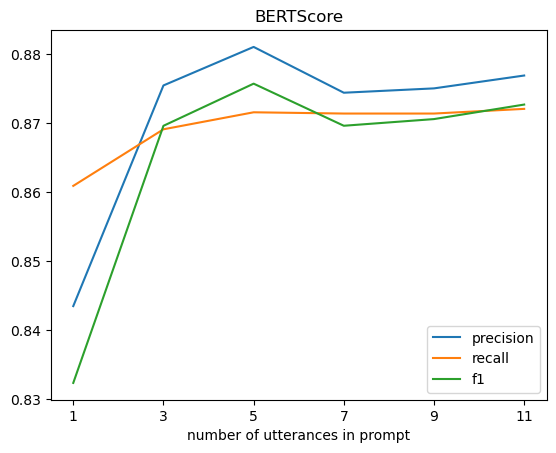

In [255]:
precision = [0.8434865599274636, 0.8754798783063888, 0.8810651062726974, 0.8744239643812179, 0.8750539583563804, 0.8769186161756516]
recall = [0.8609186807870864, 0.8691221710443496, 0.8715875070691109, 0.8714051862359047, 0.8714051862359047, 0.8720826237797737]
f1 = [0.8323477393388748, 0.8696265460848809, 0.8757399339675903, 0.8696350776553154, 0.8706021342873573, 0.8727078305482865]
dialogue_len = [1, 3, 5, 7, 9, 11]

plt.plot(dialogue_len, precision, label='precision')
plt.plot(dialogue_len, recall, label='recall')
plt.plot(dialogue_len, f1, label='f1')

plt.title('BERTScore')
plt.xlabel('number of utterances in prompt')
plt.xticks(dialogue_len, dialogue_len)
plt.legend()
plt.show()

# Experiments Length 6

In [20]:
dial_df = pd.read_csv('dialogues_with_len_2_12.csv')
dial_df

,conv_id,utterance_idx,personality,history,history_len,random_len,len_2,len_4,len_6,len_8,...,dialogue_8,dialogue_10,dialogue_12,target_2,target_4,target_6,target_8,target_10,target_12,persona
0,0,7,"['I read twenty books a year.', ""I'm a stunt d...","['Hello what are doing today?', 'I am good, I ...",15,12,"['Hello what are doing today?', 'I am good, I ...","['Hello what are doing today?', 'I am good, I ...","['Hello what are doing today?', 'I am good, I ...","['Hello what are doing today?', 'I am good, I ...",...,HUMAN: Hello what are doing today?\nPERSON: I ...,HUMAN: Hello what are doing today?\nPERSON: I ...,HUMAN: Hello what are doing today?\nPERSON: I ...,"I am good, I just got off work and tired, I ha...","I rather read, I've read about 20 books this y...",But a good movie is always good.,I work in the movies as well.,"Yes it is neat, I stunt double, it is so much ...","Nice, I only have one parent so now I help out...",I read twenty books a year. I'm a stunt double...
1,1,6,"['I have two dogs.', 'I like to work on vintag...","['Hi! how are you doing tonight?', ""I'm doing ...",13,2,"['Hi! how are you doing tonight?', ""I'm doing ...","['Hi! how are you doing tonight?', ""I'm doing ...","['Hi! how are you doing tonight?', ""I'm doing ...","['Hi! how are you doing tonight?', ""I'm doing ...",...,HUMAN: Hi! how are you doing tonight?\nPERSON:...,HUMAN: Hi! how are you doing tonight?\nPERSON:...,HUMAN: Hi! how are you doing tonight?\nPERSON:...,I'm doing great. Just relaxing with my two dogs.,That's neat. What kind of volunteer work do yo...,Good for you. Do you like vintage cars? I've t...,Cars are my thing. Vintage cars. I love workin...,I didn't think about the crowd aspect of wrest...,I agree. Working out is a great way to burn of...,I have two dogs. I like to work on vintage car...
2,2,6,"['I love disneyland and mickey mouse.', 'I lov...","['Hello, how are you doing?', 'I love spending...",13,2,"['Hello, how are you doing?', 'I love spending...","['Hello, how are you doing?', 'I love spending...","['Hello, how are you doing?', 'I love spending...","['Hello, how are you doing?', 'I love spending...",...,"HUMAN: Hello, how are you doing?\nPERSON: I lo...","HUMAN: Hello, how are you doing?\nPERSON: I lo...","HUMAN: Hello, how are you doing?\nPERSON: I lo...",I love spending time with my family.,So then have you ever been to disneyland?,Yes I love mickey mouse such a cute little rat.,Man your lucky I am a baby delivery nurse and ...,I have to walk 3 miles to work to save money e...,Your economic skills are amazing.,I love disneyland and mickey mouse. I love to ...
3,3,6,"['I love to drink fancy tea.', 'I have a big l...",['Hi how are you doing? I am okay how about yo...,13,12,['Hi how are you doing? I am okay how about yo...,['Hi how are you doing? I am okay how about yo...,['Hi how are you doing? I am okay how about yo...,['Hi how are you doing? I am okay how about yo...,...,HUMAN: Hi how are you doing? I am okay how abo...,HUMAN: Hi how are you doing? I am okay how abo...,HUMAN: Hi how are you doing? I am okay how abo...,I am doing good. Just sipping tea. What do you...,I am sorry to hear that. What happened.,So what do you do now for fun? I like to read.,What kind of dogs do you have?,I love reading. I have a big library at my house.,I've a tough time hearing so reading is my hap...,I love to drink fancy tea. I have a big librar...
4,4,6,"[""I'm a little girl."", ""I've superpowers."", 'I...","['Hi I dye my hair 4 times a year.', 'Do you l...",13,6,"['Hi I dye my hair 4 times a year.', 'Do you l...","['Hi I dye my hair 4 times a year.', 'Do you l...","['Hi I dye my hair 4 times a year.', 'Do you l...","['Hi I dye my hair 4 times a year.', 'Do you l...",...,HUMAN: Hi I dye my hair 4 times a year.\nPERSO...,HUMAN: Hi I dye my hair 4 times a year.\nPERSO...,HUMAN: Hi I dye my hair 4 times a year.\nPERSO...,Do you live in the sky? I do. in the clouds.,I make time stop. I've a superpower. I'm a sup...,I love living in the

In [21]:
dial_df['dialogue_6'][0]

"HUMAN: Hello what are doing today?\nPERSON: I am good, I just got off work and tired, I have two jobs.\nHUMAN: I just got done watching a horror movie.\nPERSON: I rather read, I've read about 20 books this year.\nHUMAN: Wow! I do love a good horror movie. Loving this cooler weather.\nPERSON:"

In [22]:
def make_pers_dial_prompt(persona, dialogue):
    return 'PERSONALITY: ' + persona + '\n' + 'DIALOGUE:\n' + dialogue

In [36]:
def make_cherry_example_pers_dial_prompt(persona, dialogue):
    #conv_id = 17
    cherry_picked_example = """PERSONALITY: I'm scared of clowns. I've two dogs. I like to cook. I have two roomates. I live on the third floor in an apartment.
DIALOGUE:
HUMAN: Hi. How are you doing today?
PERSON: Hi! I am good! Just playing with my dogs!
HUMAN: How many dogs do you have?
PERSON: I have 2. It is annoying taking them outside from the third floor.
HUMAN: That sounds like a lot of work.
PERSON: It is, but my roommates help out sometimes.
HUMAN: That's really nice of them.
PERSON: They're nice. I cook for them in appreciation of their help.

"""
    return cherry_picked_example + 'PERSONALITY: ' + persona + '\n' + 'DIALOGUE:\n' + dialogue

In [24]:
def make_instr_prompt(task, persona, dialogue):
    return 'TASK: ' + task + '\n' + 'PERSONALITY: ' + persona + '\n' + 'DIALOGUE:\n' + dialogue

In [35]:
def make_cherry_task_pers_dial_prompt(task, persona, dialogue):
    #conv_id = 17
    cherry_picked_example = """PERSONALITY: I'm scared of clowns. I've two dogs. I like to cook. I have two roomates. I live on the third floor in an apartment.
DIALOGUE:
HUMAN: Hi. How are you doing today?
PERSON: Hi! I am good! Just playing with my dogs!
HUMAN: How many dogs do you have?
PERSON: I have 2. It is annoying taking them outside from the third floor.
HUMAN: That sounds like a lot of work.
PERSON: It is, but my roommates help out sometimes.
HUMAN: That's really nice of them.
PERSON: They're nice. I cook for them in appreciation of their help.

"""
    return 'TASK: ' + task + '\n' + cherry_picked_example + 'TASK:' + task + '\n' + 'PERSONALITY: ' + persona + '\n' + 'DIALOGUE:\n' + dialogue

In [26]:
def make_task_rand_pers_dial_prompts(task, rand_example, rand_target, persona, dialogue):
    return 'TASK: ' + task + '\n' + rand_example + ' ' + rand_target + '\n\n' + 'TASK:' + task + '\n' + 'PERSONALITY: ' + persona + '\n' + 'DIALOGUE:\n' + dialogue

In [27]:
task = 'Respond to the HUMAN in the DIALOGUE according to your PERSONALITY.'

In [29]:
pers_dial_prompts = make_pers_dial_prompt(dial_df['persona'], dial_df['dialogue_6'])
print(pers_dial_prompts[0])

PERSONALITY: I read twenty books a year. I'm a stunt double as my second job. I only eat kosher. I was raised in a single parent household.
DIALOGUE:
HUMAN: Hello what are doing today?
PERSON: I am good, I just got off work and tired, I have two jobs.
HUMAN: I just got done watching a horror movie.
PERSON: I rather read, I've read about 20 books this year.
HUMAN: Wow! I do love a good horror movie. Loving this cooler weather.
PERSON:


In [30]:
def process_output_ith(ans, prompts, valid, i):
    resized = resize_out(ans)
    clear = clear_out(prompts, resized)
    df = pd.DataFrame(resized)
    df.rename(columns={0: "output"}, inplace=True)
    df['pred'] = pd.Series(clear)
    df['target'] = valid[f'target_{i}']
    return df

In [31]:
def prompt_pipeline(prompts, df, name):
    ans = generate_ans(prompts)
    outs = process_output_ith(ans, prompts, df, 6)
    outs.to_csv(f'{name}.csv')
    print('BERTScore\n')
    print(compute_bertscore_mean(bertscore, outs['pred'].to_list(), outs['target'].to_list()))
    print()
    print(outs[outs['pred'] == ''].shape)

In [32]:
prompt_pipeline(pers_dial_prompts, dial_df, 'output_pers_dial_length_6')

  0%|          | 0/125 [00:00<?, ?it/s]

BERTScore

(0.8773224918842316, 0.8729166913628578, 0.8725357226133347)

(6, 3)


In [37]:
cherry_pers_dial_prompts = make_cherry_example_pers_dial_prompt(dial_df['persona'], dial_df['dialogue_6'])
print(cherry_pers_dial_prompts[0])

PERSONALITY: I'm scared of clowns. I've two dogs. I like to cook. I have two roomates. I live on the third floor in an apartment.
DIALOGUE:
HUMAN: Hi. How are you doing today?
PERSON: Hi! I am good! Just playing with my dogs!
HUMAN: How many dogs do you have?
PERSON: I have 2. It is annoying taking them outside from the third floor.
HUMAN: That sounds like a lot of work.
PERSON: It is, but my roommates help out sometimes.
HUMAN: That's really nice of them.
PERSON: They're nice. I cook for them in appreciation of their help.

PERSONALITY: I read twenty books a year. I'm a stunt double as my second job. I only eat kosher. I was raised in a single parent household.
DIALOGUE:
HUMAN: Hello what are doing today?
PERSON: I am good, I just got off work and tired, I have two jobs.
HUMAN: I just got done watching a horror movie.
PERSON: I rather read, I've read about 20 books this year.
HUMAN: Wow! I do love a good horror movie. Loving this cooler weather.
PERSON:


In [38]:
prompt_pipeline(cherry_pers_dial_prompts, dial_df, 'output_cherry_pers_dial_len_6')

  0%|          | 0/125 [00:00<?, ?it/s]

BERTScore

(0.8799981773495674, 0.8733761557936668, 0.8744687707424164)

(5, 3)


# Evaluation of Results

In [14]:
from datasets import load_metric
import pandas as pd
import numpy as np
from evaluate import load
import statistics

In [15]:
!pip install rouge-score

In [16]:
bertscore = load("bertscore")
rouge = load('rouge')

In [371]:
names = ['output_task_pers_dial_random_1.csv',
        'output_zeroshot_random_1.csv',
        'output_pers_dial_random_1.csv',
        'output_cherry_pers_dial_random_1.csv',
        'output_cherry_task_pers_dial_random_1.csv',
        'output_random_eg_pers_dial_1.csv',
        'output_task_random_eg_pers_dial_1.csv',
        'output_pers_dial_length_2.csv',
        'output_pers_dial_length_4.csv',
        'output_pers_dial_length_6.csv',
        'output_pers_dial_length_8.csv',
        'output_pers_dial_length_10.csv',
        'output_pers_dial_length_12.csv'
        ]

In [17]:
def compute_bertscore_mean(bertscore, preds, targets):
    results = bertscore.compute(predictions=preds, references=targets, lang="en")
    precision = statistics.mean(results['precision'])
    recall = statistics.mean(results['recall'])
    f1 = statistics.mean(results['f1'])
    return precision, recall, f1

In [18]:
def compute_rougescore(rouge, preds, targets):
    return rouge.compute(predictions=preds, references=targets)

In [19]:
def evaluate_ans(name):
    df = pd.read_csv(name)
    df.fillna('', inplace=True)
    preds = df['pred'].to_list()
    targets = df['target'].to_list()
    
    bertscore_tuple = compute_bertscore_mean(bertscore, preds, targets)
    print(bertscore_tuple)
    rouge_dict = compute_rougescore(rouge, preds, targets)
    print(rouge_dict)
    empty = df[df['pred'] == ''].shape[0]
    print(empty)
    
    return {'filename': name, 'bertscore_precision': bertscore_tuple[0], 'bertscore_recall': bertscore_tuple[1], 
            'bertscore_f1': bertscore_tuple[2], 'rougescore_rouge1': rouge_dict['rouge1'], 'rougescore_rouge2': rouge_dict['rouge2'],
            'rougescore_rougeL': rouge_dict['rougeL'], 'rougescore_rougeLsum': rouge_dict['rougeLsum'], 'empty': empty}

In [404]:
eval_res = pd.DataFrame({'filename': names})
eval_res

,filename
0,output_task_pers_dial_random_1.csv
1,output_zeroshot_random_1.csv
2,output_pers_dial_random_1.csv
3,output_cherry_pers_dial_random_1.csv
4,output_cherry_task_pers_dial_random_1.csv
5,output_random_eg_pers_dial_1.csv
6,output_task_random_eg_pers_dial_1.csv
7,output_pers_dial_length_2.csv
8,output_pers_dial_length_4.csv
9,output_pers_dial_length_6.csv


In [405]:
eval_res = {'filename': [], 'bertscore_precision': [], 'bertscore_recall': [], 'bertscore_f1': [], 
            'rougescore_rouge1': [], 'rougescore_rouge2': [], 'rougescore_rougeL': [], 'rougescore_rougeLsum': [], 'empty': []}
for name in names:
    curr_res = evaluate_ans(name)
    for key in curr_res:
        eval_res[key].append(curr_res[key])

df_res = pd.DataFrame(eval_res)

(0.8707919208407402, 0.8713589745163918, 0.8652176014184951)
{'rouge1': 0.14001747318894087, 'rouge2': 0.023399327580458783, 'rougeL': 0.1279092645154086, 'rougeLsum': 0.1281877612294407}
14


(0.863828986287117, 0.8676085439920426, 0.8577798662185669)
{'rouge1': 0.11885593893645462, 'rouge2': 0.018569907006256686, 'rougeL': 0.11077700079132488, 'rougeLsum': 0.1107949092536165}
19


(0.8679948578476906, 0.8695913112163544, 0.8616972988247872)
{'rouge1': 0.13006860735933065, 'rouge2': 0.02012701498502921, 'rougeL': 0.12119955056869632, 'rougeLsum': 0.12120396464895908}
17


(0.8737019658088684, 0.8717788278460502, 0.8681086091995239)
{'rouge1': 0.14284877917461725, 'rouge2': 0.02463448948868569, 'rougeL': 0.1321996427548584, 'rougeLsum': 0.13224474082692084}
11


(0.8669933337569237, 0.8722414824962615, 0.8617919453978539)
{'rouge1': 0.14372537703766064, 'rouge2': 0.026451033551395782, 'rougeL': 0.13257550050570574, 'rougeLsum': 0.13283212996955274}
19


(0.8727153671979904, 0.871231037735939, 0.8677872304320335)
{'rouge1': 0.1346990601267923, 'rouge2': 0.020726655295661374, 'rougeL': 0.12358996790259477, 'rougeLsum': 0.12345915117463088}
10


(0.871926793038845, 0.8710275685787201, 0.8668279539942741)
{'rouge1': 0.13463424466870627, 'rouge2': 0.02278106270434344, 'rougeL': 0.12365939951822541, 'rougeLsum': 0.12341065040056032}
11


(0.8434865599274636, 0.8609186807870864, 0.8323477393388748)
{'rouge1': 0.13161619624290355, 'rouge2': 0.03463680257539298, 'rougeL': 0.12453755852309185, 'rougeLsum': 0.12442641054133438}
48


(0.8754798783063888, 0.8691221710443496, 0.8696265460848809)
{'rouge1': 0.13316080107849637, 'rouge2': 0.021198743683712152, 'rougeL': 0.12311976326514139, 'rougeLsum': 0.12307542133719637}
6


(0.8810651062726974, 0.8715875070691109, 0.8757399339675903)
{'rouge1': 0.1315067416826071, 'rouge2': 0.015400373864928865, 'rougeL': 0.12013970744421118, 'rougeLsum': 0.1201387940948109}
1


(0.8744239643812179, 0.8701296406388283, 0.8696350776553154)
{'rouge1': 0.1319409988220313, 'rouge2': 0.016812784207478795, 'rougeL': 0.12087147201718096, 'rougeLsum': 0.12091877973022819}
6


(0.8750539583563804, 0.8714051862359047, 0.8706021342873573)
{'rouge1': 0.12869982404803976, 'rouge2': 0.018672052993692633, 'rougeL': 0.1198454617192383, 'rougeLsum': 0.11989706500930891}
6


(0.8769186161756516, 0.8720826237797737, 0.8727078305482865)
{'rouge1': 0.12917991593062295, 'rouge2': 0.016944337267238537, 'rougeL': 0.11904790835378035, 'rougeLsum': 0.11918069806300427}
4


In [406]:
df_res

,filename,bertscore_precision,bertscore_recall,bertscore_f1,rougescore_rouge1,rougescore_rouge2,rougescore_rougeL,rougescore_rougeLsum,empty
0,output_task_pers_dial_random_1.csv,0.870792,0.871359,0.865218,0.140017,0.023399,0.127909,0.128188,14
1,output_zeroshot_random_1.csv,0.863829,0.867609,0.857780,0.118856,0.018570,0.110777,0.110795,19
2,output_pers_dial_random_1.csv,0.867995,0.869591,0.861697,0.130069,0.020127,0.121200,0.121204,17
3,output_cherry_pers_dial_random_1.csv,0.873702,0.871779,0.868109,0.142849,0.024634,0.132200,0.132245,11
4,output_cherry_task_pers_dial_random_1.csv,0.866993,0.872241,0.861792,0.143725,0.026451,0.132576,0.132832,19
5,output_random_eg_pers_dial_1.csv,0.872715,0.871231,0.867787,0.134699,0.020727,0.123590,0.123459,10
6,output_task_random_eg_pers_dial_1.csv,0.871927,0.871028,0.866828,0.134634,0.022781,0.123659,0.123411,11
7,output_pers_dial_length_2.csv,0.843487,0.860919,0.832348,0.131616,0.034637,0.124538,0.124426,48
8,output_pers_dial_length_4.csv,0.875480,0.869122,0.869627,0.133161,0.021199,0.123120,0.123075,6
9,output_pers_dial_length_6.csv,0.881065,0.871588,0.875740,0.131507,0.015400,0.120140,0.120139,1


In [407]:
df_res.to_csv('evaluation_results_bertscore_rouge_empty.csv')